<a href="https://colab.research.google.com/github/Raswanth-Prasath/NGSIM-Driving-Behavior-Analysis/blob/main/NGSIM_Driving_Behavior_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple

@dataclass
class CarFollowingPair:
    """
    Represents a validated car-following pair with all relevant information
    """
    leader_id: int
    follower_id: int
    
    start_frame: int
    end_frame: int
    lane_id: int
    
    metrics: Dict = None

    @property
    def duration(self) -> float:
        """Duration of car-following episode in seconds"""
        return (self.end_frame - self.start_frame + 1) * 0.1  # Convert frames to seconds

class CarFollowingIdentifier:
    """
    Identifies and validates car-following pairs in trajectory data
    """
    def __init__(self, min_duration: float = 20.0,
                 min_spacing: float = 2.0,
                 max_spacing: float = 100.0):
        """
        Initialize with validation criteria
        
        Parameters:
        min_duration: Minimum duration in seconds for valid car-following
        min_spacing: Minimum allowed spacing between vehicles (meters)
        max_spacing: Maximum allowed spacing between vehicles (meters)
        """
        self.min_duration = min_duration
        self.min_frames = int(min_duration * 10)  # Convert to frames (0.1s intervals)
        self.min_spacing = min_spacing
        self.max_spacing = max_spacing
        
    def identify_pairs(self, df: pd.DataFrame) -> List[CarFollowingPair]:
        """
        Main method to identify valid car-following pairs, with integrated leader-follower validation
        
        Parameters:
        df: DataFrame with columns for Vehicle_ID, Frame_ID, Lane_ID, LocalY, Leader_ID, Follower_ID
        
        Returns:
        List of validated CarFollowingPair objects
        """
        valid_pairs = []
        pairs_before_validation = 0
        pairs_after_validation = 0
        
        # Step 1: Group data by lane
        for lane_id, lane_data in df.groupby('Lane_ID'):
            # Skip special lanes (like merge lanes or shoulders)
            if lane_id > 6:  # Assuming regular lanes are 1-6
                continue
                
            # Step 2: Process each time window in the lane
            frames = sorted(lane_data['Frame_ID'].unique())
            
            # Step 3: Track ongoing pairs
            current_pairs = {}
            
            for frame in frames:
                frame_data = lane_data[lane_data['Frame_ID'] == frame]
                
                # Sort vehicles by position to identify leader-follower relationships
                frame_vehicles = frame_data.sort_values('LocalY', ascending=False)
                
                # Step 4: Check each consecutive pair of vehicles
                for i in range(len(frame_vehicles) - 1):
                    leader = frame_vehicles.iloc[i]
                    follower = frame_vehicles.iloc[i + 1]
                    
                    # Calculate spacing
                    spacing = leader['LocalY'] - follower['LocalY']
                    pairs_before_validation += 1
                    
                    # Get vehicle IDs for relationship validation
                    leader_id = leader['Vehicle_ID']
                    follower_id = follower['Vehicle_ID']
                    follower_leader_id = follower['Leader_ID']
                    leader_follower_id = leader['Follower_ID']
                    
                    # Validate the leader-follower relationship:
                    # 1. If explicit relationships exist (non -1), they must be correct
                    # 2. If no explicit relationships (-1), allow validation by spacing
                    valid_relationship = False
                    
                    if follower_leader_id != -1 or leader_follower_id != -1:
                        # At least one explicit relationship exists - it must be correct
                        leader_match = follower_leader_id == leader_id
                        follower_match = leader_follower_id == follower_id
                        valid_relationship = leader_match or follower_match
                    else:
                        # No explicit relationships - allow validation by spacing
                        valid_relationship = True
                    
                    # Both the relationship and spacing must be valid
                    if valid_relationship and self.min_spacing <= spacing <= self.max_spacing:
                        pairs_after_validation += 1
                        pair_id = (leader_id, follower_id)
                        
                        if pair_id not in current_pairs:
                            # Start new pair tracking
                            current_pairs[pair_id] = {
                                'start_frame': frame,
                                'current_frame': frame,
                                'lane_id': lane_id
                            }
                        else:
                            # Update existing pair
                            current_pairs[pair_id]['current_frame'] = frame
                    else:
                        # Invalid pair - end pair if exists
                        pair_id = (leader_id, follower_id)
                        self._check_and_add_pair(current_pairs, pair_id, valid_pairs)
                
            # Process any remaining pairs at the end of the lane
            for pair_id in list(current_pairs.keys()):
                self._check_and_add_pair(current_pairs, pair_id, valid_pairs)
        
        print(f"Pairs before validation: {pairs_before_validation}")
        print(f"Pairs after validation: {pairs_after_validation}")
        return valid_pairs
    
    def _check_and_add_pair(self, current_pairs: Dict, 
                           pair_id: Tuple[int, int],
                           valid_pairs: List[CarFollowingPair]) -> None:
        """
        Validates and adds a car-following pair if it meets duration criteria
        """
        if pair_id in current_pairs:
            pair_data = current_pairs[pair_id]
            duration_frames = pair_data['current_frame'] - pair_data['start_frame'] + 1
            
            if duration_frames >= self.min_frames:
                # Create validated pair
                valid_pairs.append(CarFollowingPair(
                    leader_id=pair_id[0],
                    follower_id=pair_id[1],
                    start_frame=pair_data['start_frame'],
                    end_frame=pair_data['current_frame'],
                    lane_id=pair_data['lane_id']
                ))
            
            # Remove pair from tracking
            del current_pairs[pair_id]
    
    def compute_pair_metrics(self, pair: CarFollowingPair, df: pd.DataFrame) -> Dict:
        """
        Computes detailed metrics for a validated car-following pair with proper handling of zero speeds
        
        Parameters:
        pair: CarFollowingPair object
        df: Original trajectory DataFrame
        
        Returns:
        Dictionary of computed metrics
        """
        # Get leader and follower trajectories
        leader_data = df[(df['Vehicle_ID'] == pair.leader_id) & 
                        (df['Frame_ID'] >= pair.start_frame) & 
                        (df['Frame_ID'] <= pair.end_frame)]
        
        follower_data = df[(df['Vehicle_ID'] == pair.follower_id) & 
                        (df['Frame_ID'] >= pair.start_frame) & 
                        (df['Frame_ID'] <= pair.end_frame)]
        
        # Compute spacing statistics
        spacing = leader_data['LocalY'].values - follower_data['LocalY'].values
        
        # Compute speed difference statistics
        speed_diff = leader_data['Speed'].values - follower_data['Speed'].values
        
        # Compute time headway with careful handling of zero speeds
        follower_speeds = follower_data['Speed'].values
        
        # Create a mask for non-zero speeds to avoid division by zero
        non_zero_speed_mask = follower_speeds > 0.01  # Small threshold to handle near-zero speeds
        
        # Only calculate time headway where speed is non-zero
        if np.any(non_zero_speed_mask):
            # Calculate time headway only for non-zero speeds
            valid_spacings = spacing[non_zero_speed_mask]
            valid_speeds = follower_speeds[non_zero_speed_mask]
            time_headway = valid_spacings / valid_speeds
            
            # Remove any extreme values that might still occur
            reasonable_headway_mask = (time_headway > 0) & (time_headway < 20)  # Filter unreasonable values
            valid_headway = time_headway[reasonable_headway_mask] if np.any(reasonable_headway_mask) else np.array([])
        else:
            # No valid speeds for calculation
            valid_headway = np.array([])
        
        # Handle empty arrays for edge cases
        if len(valid_headway) == 0:
            headway_stats = {
                'mean': np.nan,
                'std': np.nan,
                'min': np.nan,
                'max': np.nan
            }
        else:
            headway_stats = {
                'mean': np.mean(valid_headway),
                'std': np.std(valid_headway),
                'min': np.min(valid_headway),
                'max': np.max(valid_headway)
            }
        
        return {
            'spacing': {
                'mean': np.mean(spacing),
                'std': np.std(spacing),
                'min': np.min(spacing),
                'max': np.max(spacing)
            },
            'speed_difference': {
                'mean': np.mean(speed_diff),
                'std': np.std(speed_diff),
                'min': np.min(speed_diff),
                'max': np.max(speed_diff)
            },
            'time_headway': headway_stats
        }

def main():
    # Example usage
    # Read the data file
    df = pd.read_csv("D:\ASU Academics\Traffic Flow Theroy\MP-1\Reconstructed NGSIM I80-1 data\Data\DATA (NO MOTORCYCLES).txt", delimiter='\s+', header=None,
                     names=['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                           'Speed', 'Acceleration', 'Vehicle_Length',
                           'Vehicle_Class', 'Follower_ID', 'Leader_ID'])
    
    # Initialize identifier
    identifier = CarFollowingIdentifier(
        min_duration=20.0,  # 20 seconds minimum
        min_spacing=2.0,    # 2 meters minimum spacing
        max_spacing=100.0   # 100 meters maximum spacing
    )
    
    # Find car-following pairs
    all_pairs = identifier.identify_pairs(df)
    
    # Print summary
    print(f"Found {len(all_pairs)} valid car-following pairs")
    
    # Export all pairs to CSV
    export_pairs_to_csv(all_pairs, df, identifier, "all_car_following_pairs.csv")
    
    # Select the specific pairs we want
    selected_pairs = []
    selected_pair_ids = [
        (1087.0, 1101.0),  # Pair 57 - Aggressive Following with Large Speed Difference
        (120.0, 125.0),    # Pair 13 - Very Close Following
        (2066.0, 2074.0),  # Pair 96 - Conservative Following with Large Spacing
        (1463.0, 1478.0),  # Pair 714 - Lane 3 with Medium Following Distance
        (260.0, 267.0)     # Pair 238 - Stable Following with Small Speed Difference
    ]
    
    # Find these pairs in our identified pairs
    for pair in all_pairs:
        if (pair.leader_id, pair.follower_id) in selected_pair_ids:
            selected_pairs.append(pair)
    
    print(f"Selected {len(selected_pairs)} specific car-following pairs for analysis")
    
    # Export selected pairs to a separate CSV
    export_pairs_to_csv(selected_pairs, df, identifier, "selected_car_following_pairs.csv")
    
    # Analyze each selected pair
    for i, pair in enumerate(selected_pairs):
        print(f"\nPair {i+1}:")
        print(f"Leader ID: {pair.leader_id}")
        print(f"Follower ID: {pair.follower_id}")
        print(f"Duration: {pair.duration:.1f} seconds")
        print(f"Lane: {pair.lane_id}")
        
        # Compute and print metrics
        metrics = identifier.compute_pair_metrics(pair, df)
        print("\nMetrics:")
        for metric, values in metrics.items():
            print(f"\n{metric}:")
            for stat, value in values.items():
                print(f"  {stat}: {value:.2f}")

def export_pairs_to_csv(pairs, df, identifier, filename):
    """
    Export all car-following pairs with their metrics to a CSV file
    
    Parameters:
    pairs: List of CarFollowingPair objects
    df: Original trajectory DataFrame
    identifier: CarFollowingIdentifier instance for computing metrics
    filename: Name of the output CSV file
    """
    # Prepare a list to hold all pair data
    all_pairs_data = []
    
    # Process each pair
    for i, pair in enumerate(pairs):
        # Compute metrics for this pair
        metrics = identifier.compute_pair_metrics(pair, df)
        
        # Create a dictionary with all relevant data
        pair_data = {
            'pair_id': i + 1,
            'leader_id': pair.leader_id,
            'follower_id': pair.follower_id,
            'start_frame': pair.start_frame,
            'end_frame': pair.end_frame,
            'lane_id': pair.lane_id,
            'duration_seconds': pair.duration,
            'mean_spacing': metrics['spacing']['mean'],
            'std_spacing': metrics['spacing']['std'],
            'min_spacing': metrics['spacing']['min'],
            'max_spacing': metrics['spacing']['max'],
            'mean_speed_diff': metrics['speed_difference']['mean'],
            'std_speed_diff': metrics['speed_difference']['std'],
            'min_speed_diff': metrics['speed_difference']['min'],
            'max_speed_diff': metrics['speed_difference']['max'],
            'mean_time_headway': metrics['time_headway']['mean'],
            'std_time_headway': metrics['time_headway']['std'],
            'min_time_headway': metrics['time_headway']['min'],
            'max_time_headway': metrics['time_headway']['max']
        }
        
        all_pairs_data.append(pair_data)
    
    # Convert to DataFrame
    pairs_df = pd.DataFrame(all_pairs_data)
    
    # Save to CSV
    pairs_df.to_csv(filename, index=False)
    print(f"Exported {len(pairs)} car-following pairs to {filename}")
        
if __name__ == "__main__":
    main()

Pairs before validation: 966462
Pairs after validation: 963929
Found 2029 valid car-following pairs
Exported 2029 car-following pairs to all_car_following_pairs.csv
Selected 5 specific car-following pairs for analysis
Exported 5 car-following pairs to selected_car_following_pairs.csv

Pair 1:
Leader ID: 120.0
Follower ID: 125.0
Duration: 28.1 seconds
Lane: 1

Metrics:

spacing:
  mean: 17.80
  std: 6.47
  min: 10.29
  max: 28.33

speed_difference:
  mean: 0.28
  std: 1.40
  min: -3.13
  max: 3.17

time_headway:
  mean: 1.30
  std: 0.23
  min: 1.00
  max: 1.78

Pair 2:
Leader ID: 1087.0
Follower ID: 1101.0
Duration: 20.1 seconds
Lane: 1

Metrics:

spacing:
  mean: 37.24
  std: 17.02
  min: 17.05
  max: 65.33

speed_difference:
  mean: 2.25
  std: 1.86
  min: -2.29
  max: 5.32

time_headway:
  mean: 2.14
  std: 0.68
  min: 1.25
  max: 3.24

Pair 3:
Leader ID: 2066.0
Follower ID: 2074.0
Duration: 22.3 seconds
Lane: 1

Metrics:

spacing:
  mean: 45.91
  std: 8.10
  min: 35.46
  max: 64.52


Analyzes statistical properties of car-following pairs and generates comprehensive visualizations and analyses.

**Car-Following Visualization and Calibration**

The following code uses the car_following_pairs.csv file generated from the previous code to analyze the car-following pairs and plot the results.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import logging
import os

# Configure logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

def load_data(file_path):
    """Load and process the trajectory data"""
    try:
        # Read data with numbered columns first
        data = pd.read_csv(file_path, delimiter='\s+', header=None)
        
        # Rename columns to match expected format
        data.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'Local_Y', 
                       'Speed', 'Acceleration', 'Vehicle_Length',
                       'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        
        logger.info(f"Successfully loaded data with {len(data)} rows")
        return data
        
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()

def load_selected_pairs(csv_path):
    """Load previously identified car-following pairs from CSV"""
    try:
        pairs_df = pd.read_csv(csv_path)
        
        # Convert DataFrame rows to list of pair dictionaries
        selected_pairs = []
        for _, row in pairs_df.iterrows():
            pair = {
                'leader_id': row['leader_id'],
                'follower_id': row['follower_id'],
                'start_frame': row['start_frame'],
                'end_frame': row['end_frame'],
                'lane': row['lane_id'],
                'duration': row['duration_seconds'],
                'description': f"Mean spacing: {row['mean_spacing']:.1f}m, Mean time headway: {row['mean_time_headway']:.1f}s"
            }
            selected_pairs.append(pair)
            
        logger.info(f"Loaded {len(selected_pairs)} car-following pairs from {csv_path}")
        return selected_pairs
        
    except Exception as e:
        logger.error(f"Error loading selected pairs: {e}")
        return []

def process_pair_data(data, selected_pairs):
    """Process data for selected car-following pairs"""
    pair_data = []
    
    for i, pair in enumerate(selected_pairs):
        # Get trajectory data for leader and follower
        frames = range(int(pair['start_frame']), int(pair['end_frame']) + 1)
        
        leader_data = data[
            (data['Vehicle_ID'] == pair['leader_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        follower_data = data[
            (data['Vehicle_ID'] == pair['follower_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        # Combine data
        merged_data = pd.merge(
            leader_data, 
            follower_data,
            on='Frame_ID',
            suffixes=('_leader', '_follower')
        )
        
        # Skip pairs with no merged data
        if len(merged_data) == 0:
            logger.warning(f"Skipping pair {i+1} ({pair['leader_id']}-{pair['follower_id']}) due to empty merged data")
            continue
            
        time_data = []
        for _, row in merged_data.iterrows():
            time_data.append({
                'time': (row['Frame_ID'] - pair['start_frame']) * 0.1,
                'leader_speed': row['Speed_leader'],
                'follower_speed': row['Speed_follower'],
                'leader_accel': row['Acceleration_leader'],
                'follower_accel': row['Acceleration_follower'],
                'spacing': row['Local_Y_leader'] - row['Local_Y_follower'] - row['Vehicle_Length_leader'],
                'relative_speed': row['Speed_leader'] - row['Speed_follower']
            })
        
        pair_data.append({
            'pair_id': f"{pair['leader_id']}-{pair['follower_id']}",
            'description': pair.get('description', ''),
            'lane': pair['lane'],
            'duration': pair['duration'],
            'time_data': pd.DataFrame(time_data)
        })
    
    return pair_data

def perform_pareto_analysis(pair_data, output_dir=".", fixed_tau=1.5):
    """
    Perform Pareto analysis for CTH-RV model parameters with pair-specific ranges.
    
    Args:
        pair_data: List of dictionaries or single dictionary containing trajectory data for each pair
        output_dir: Directory to save output visualizations
        fixed_tau: Fixed value for tau parameter
    """
    if not isinstance(pair_data, list):
        pair_data = [pair_data]
    
    all_results = {}
        
    for pair in pair_data:
        try:
            time_data = pair['time_data']
            pair_id = pair['pair_id']
            
            # Define pair-specific parameter ranges
            parameter_ranges = {
                "120.0-125.0": {
                    "alpha": (-0.01, 0.01),
                    "beta": (0, 0.80) 
                },
                "1087.0-1101.0": {
                    "alpha": (-0.05, 0.09),
                    "beta": (-0.2, 0.4)
                },
                "2066.0-2074.0": {
                    "alpha": (-0.01, 0.04),
                    "beta": (0.05, 0.32) 
                },
                "260.0-267.0": {
                    "alpha": (-0.01, 0.1),
                    "beta": (-0.05, 0.05) 
                },
                "1463.0-1478.0": {
                    "alpha":  (0.9, 1.1),
                    "beta": (-0.675, -0.475) 
                }
            }
            
            # Get pair-specific parameter ranges
            if pair_id in parameter_ranges:
                alpha_min, alpha_max = parameter_ranges[pair_id]["alpha"]
                beta_min, beta_max = parameter_ranges[pair_id]["beta"]
            else:
                # Use default ranges if pair not found
                alpha_min, alpha_max = 0.05, 0.5
                beta_min, beta_max = 0.5, 1.5
            
            logger.info(f"Performing Pareto analysis for pair {pair_id} with parameter ranges: " 
                       f"alpha=[{alpha_min}, {alpha_max}], beta=[{beta_min}, {beta_max}]")
            
            # Create parameter grids
            alpha_range = np.linspace(alpha_min, alpha_max, 30)
            beta_range = np.linspace(beta_min, beta_max, 30)     
            alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)
            
            # Convert values to numpy arrays if they aren't already
            times = np.array(time_data['time'])
            actual_speeds = np.array(time_data['follower_speed'])
            actual_spacings = np.array(time_data['spacing'])
            relative_speeds = np.array(time_data['relative_speed'])
            dt = times[1] - times[0] if len(times) > 1 else 0.1  # Get dt from data or default to 0.1s
            
            # Initialize error arrays
            speed_errors = np.zeros_like(alpha_grid)
            spacing_errors = np.zeros_like(alpha_grid)
            combined_errors = np.zeros_like(alpha_grid)
            
            # Simulate trajectories for each parameter combination
            for i, alpha in enumerate(alpha_range):
                for j, beta in enumerate(beta_range):
                    # Initialize simulation arrays
                    simulated_speeds = [actual_speeds[0]]
                    simulated_spacings = [actual_spacings[0]]
                    
                    # Simulate vehicle trajectory
                    for t in range(1, len(times)):
                        # Current state
                        v_prev = simulated_speeds[-1]
                        s_prev = simulated_spacings[-1]
                        
                        # CTH-RV model: a(t) = α(s(t) - τv(t)) + β∆v(t)
                        accel = alpha * (s_prev - fixed_tau * v_prev) + beta * relative_speeds[t-1]
                        
                        # Update states (Euler integration)
                        v_new = v_prev + accel * dt
                        s_new = s_prev + relative_speeds[t-1] * dt
                        
                        simulated_speeds.append(v_new)
                        simulated_spacings.append(s_new)
                    
                    # Calculate RMSE errors
                    speed_errors[j,i] = np.sqrt(np.mean(
                        (np.array(simulated_speeds) - actual_speeds)**2
                    ))
                    spacing_errors[j,i] = np.sqrt(np.mean(
                        (np.array(simulated_spacings) - actual_spacings)**2
                    ))
                    # Weighted combination of errors (equal weights)
                    combined_errors[j,i] = 0.5 * speed_errors[j,i] + 0.5 * spacing_errors[j,i]
            
            # Find optimal parameters
            min_idx = np.unravel_index(np.argmin(combined_errors), combined_errors.shape)
            optimal_alpha = alpha_range[min_idx[1]]  # Using min_idx[1] for alpha index
            optimal_beta = beta_range[min_idx[0]]    # Using min_idx[0] for beta index
            
            # Calculate stability criterion: α²τ² + 2ατβ - 2α ≥ 0
            stability_criterion = (optimal_alpha * fixed_tau)**2 + 2*optimal_alpha*fixed_tau*optimal_beta - 2*optimal_alpha
            is_stable = stability_criterion >= 0
            stability_status = "STABLE" if is_stable else "UNSTABLE"
            stability_boundary = 0
            
            if optimal_alpha != 0:
                # Calculate the stability boundary value for beta
                stability_boundary = (2*optimal_alpha - (optimal_alpha*fixed_tau)**2)/(2*optimal_alpha*fixed_tau)
            
            # Create visualizations
            create_pareto_visualizations(
                alpha_grid, beta_grid,
                speed_errors, spacing_errors, combined_errors,
                optimal_alpha, optimal_beta, fixed_tau, pair_id, output_dir
            )
            
            # Store results for this pair
            all_results[pair_id] = {
                'optimal_alpha': optimal_alpha,
                'optimal_beta': optimal_beta,
                'fixed_tau': fixed_tau,
                'min_combined_error': combined_errors[min_idx],
                'string_stable': is_stable,
                'stability_criterion': stability_criterion,
                'stability_status': stability_status,
                'stability_boundary': stability_boundary,
                'speed_rmse': speed_errors[min_idx],
                'spacing_rmse': spacing_errors[min_idx]
            }
            
            logger.info(f"Completed Pareto analysis for pair {pair_id}")
            logger.info(f"Optimal parameters: alpha={optimal_alpha:.4f}, beta={optimal_beta:.4f}")
            logger.info(f"String stability: {stability_status} (criterion: {stability_criterion:.4f})")
            logger.info(f"Combined error: {combined_errors[min_idx]:.4f}")
            
        except Exception as e:
            logger.error(f"Error performing Pareto analysis for pair {pair_id}: {e}")
            import traceback
            logger.error(traceback.format_exc())
            continue
    
    # Return results for all pairs
    return all_results

def create_pareto_visualizations(alpha_grid, beta_grid, speed_errors, 
                               spacing_errors, combined_errors, 
                               optimal_alpha, optimal_beta, tau, pair_id, output_dir):
    """
    Create Pareto analysis visualizations.
    """
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    
    # Add descriptive title
    fig.suptitle(f"CTH-RV Model Pareto Optimization Results\nPair {pair_id}, τ = {tau:.2f}s", 
                 fontsize=16, y=0.98)
    
    # 3D surface plot of combined error
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf = ax1.plot_surface(alpha_grid, beta_grid, combined_errors, 
                           cmap=cm.viridis, linewidth=0, antialiased=True)
    ax1.set_xlabel('α (alpha)')
    ax1.set_ylabel('β (beta)')
    ax1.set_zlabel('Combined Error')
    ax1.set_title('Combined Error Surface')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    # Contour plot of combined error
    ax2 = fig.add_subplot(2, 2, 2)
    contour = ax2.contourf(alpha_grid, beta_grid, combined_errors, levels=30, cmap='viridis')
    contour_lines = ax2.contour(alpha_grid, beta_grid, combined_errors, levels=10, colors='white', linestyles='dashed')
    ax2.clabel(contour_lines, inline=True, fontsize=8, fmt='%.3f')
    ax2.set_xlabel('α (alpha)')
    ax2.set_ylabel('β (beta)')
    ax2.set_title('Combined Error Contours')
    
    # Mark optimal point
    ax2.plot(optimal_alpha, optimal_beta, 'r*', markersize=15, 
            label=f'Optimal: α={optimal_alpha:.4f}, β={optimal_beta:.4f}')
    
    # Add stability boundary if possible
    if tau > 0:
        # Calculate stability boundary curve: α²τ² + 2ατβ - 2α = 0
        # Solve for β: β = (2α - α²τ²)/(2ατ)
        alphas = np.linspace(alpha_grid.min(), alpha_grid.max(), 100)
        betas_boundary = []
        for a in alphas:
            if a != 0:
                beta_boundary = (2*a - a**2 * tau**2)/(2*a*tau)
                betas_boundary.append(beta_boundary)
            else:
                betas_boundary.append(np.nan)
        
        valid_indices = ~np.isnan(betas_boundary)
        if any(valid_indices) and np.min(beta_grid) <= np.min(np.array(betas_boundary)[valid_indices]) <= np.max(beta_grid):
            ax2.plot(alphas[valid_indices], np.array(betas_boundary)[valid_indices], 
                    'r--', label='Stability Boundary')
    
    ax2.legend(loc='best')
    fig.colorbar(contour, ax=ax2)
    
    # Contour plot of speed error
    ax3 = fig.add_subplot(2, 2, 3)
    speed_contour = ax3.contourf(alpha_grid, beta_grid, speed_errors, levels=30, cmap='Blues')
    ax3.set_xlabel('α (alpha)')
    ax3.set_ylabel('β (beta)')
    ax3.set_title('Speed Error Contours')
    ax3.plot(optimal_alpha, optimal_beta, 'r*', markersize=15)
    fig.colorbar(speed_contour, ax=ax3)
    
    # Contour plot of spacing error
    ax4 = fig.add_subplot(2, 2, 4)
    spacing_contour = ax4.contourf(alpha_grid, beta_grid, spacing_errors, levels=30, cmap='Oranges')
    ax4.set_xlabel('α (alpha)')
    ax4.set_ylabel('β (beta)')
    ax4.set_title('Spacing Error Contours')
    ax4.plot(optimal_alpha, optimal_beta, 'r*', markersize=15)
    fig.colorbar(spacing_contour, ax=ax4)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    output_path = f"{output_dir}/pair_{pair_id}_pareto_analysis.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    logger.info(f"Saved Pareto visualization to {output_path}")
    plt.close()
    
    # Create separate parameter results figure
    fig2 = plt.figure(figsize=(10, 8))
    ax = fig2.add_subplot(111)
    ax.axis('off')
    
    # Create comprehensive parameter summary text
    string_stability = (optimal_alpha * tau)**2 + 2*optimal_alpha*tau*optimal_beta - 2*optimal_alpha >= 0
    status = "STABLE" if string_stability else "UNSTABLE"
    
    info_text = (
        f"CTH-RV Model Optimization Results for Pair {pair_id}\n"
        f"{'='*60}\n\n"
        f"Optimal Parameters:\n"
        f"• α (alpha): {optimal_alpha:.6f}\n"
        f"• β (beta): {optimal_beta:.6f}\n"
        f"• τ (tau): {tau:.2f} (fixed)\n\n"
        f"Performance Metrics:\n"
        f"• Combined Error: {np.min(combined_errors):.4f}\n"
        f"• Speed RMSE: {speed_errors[np.unravel_index(np.argmin(combined_errors), combined_errors.shape)]:.4f}\n"
        f"• Spacing RMSE: {spacing_errors[np.unravel_index(np.argmin(combined_errors), combined_errors.shape)]:.4f}\n\n"
        f"String Stability Analysis:\n"
        f"• Status: {status}\n"
        f"• Criterion (α²τ² + 2ατβ - 2α): {(optimal_alpha * tau)**2 + 2*optimal_alpha*tau*optimal_beta - 2*optimal_alpha:.6f}\n"
        f"• For string stability with these parameters, β must be {'greater' if optimal_alpha > 0 else 'less'} than "
        f"{(2*optimal_alpha - (optimal_alpha*tau)**2)/(2*optimal_alpha*tau):.6f} "
        f"(assuming α = {optimal_alpha:.6f}, τ = {tau:.2f})"
    )
    
    plt.figtext(0.5, 0.5, info_text, ha='center', va='center', fontsize=12, fontfamily='monospace', linespacing=1.5)
    
    # Save results summary
    results_path = f"{output_dir}/pair_{pair_id}_results.png"
    plt.savefig(results_path, dpi=300, bbox_inches='tight')
    logger.info(f"Saved results summary to {results_path}")
    plt.close()

def create_summary_table(all_results, output_dir="."):
    """Create a summary table of all calibration results"""
    if not all_results:
        logger.error("No results to summarize")
        return
        
    # Prepare data for summary table
    data = []
    for pair_id, results in all_results.items():
        data.append({
            'Pair ID': pair_id,
            'α (alpha)': f"{results['optimal_alpha']:.6f}",
            'β (beta)': f"{results['optimal_beta']:.6f}",
            'τ (tau)': f"{results['fixed_tau']:.2f}",
            'Combined Error': f"{results['min_combined_error']:.4f}",
            'Speed RMSE': f"{results.get('speed_rmse', 0):.4f}",
            'Spacing RMSE': f"{results.get('spacing_rmse', 0):.4f}",
            'String Stable': results['stability_status'],
            'Stability Criterion': f"{results['stability_criterion']:.6f}"
        })
    
    # Convert data to DataFrame for easier saving and display
    results_df = pd.DataFrame(data)
    
    # Save as CSV
    csv_path = f"{output_dir}/calibration_results.csv"
    results_df.to_csv(csv_path, index=False)
    logger.info(f"Saved calibration results to {csv_path}")
    
    # Save as formatted text file for easier viewing
    txt_path = f"{output_dir}/calibration_summary.txt"
    with open(txt_path, 'w') as f:
        f.write("CTH-RV Model Calibration Results Summary\n")
        f.write("="*80 + "\n\n")
        
        for pair_id, results in all_results.items():
            f.write(f"Pair ID: {pair_id}\n")
            f.write("-"*40 + "\n")
            f.write(f"• α (alpha): {results['optimal_alpha']:.6f}\n")
            f.write(f"• β (beta): {results['optimal_beta']:.6f}\n")
            f.write(f"• τ (tau): {results['fixed_tau']:.2f}\n")
            f.write(f"• Combined Error: {results['min_combined_error']:.4f}\n")
            f.write(f"• Speed RMSE: {results.get('speed_rmse', 0):.4f}\n")
            f.write(f"• Spacing RMSE: {results.get('spacing_rmse', 0):.4f}\n")
            f.write(f"• String Stability: {results['stability_status']}\n")
            f.write(f"• Stability Criterion: {results['stability_criterion']:.6f}\n\n")
    
    logger.info(f"Saved formatted summary to {txt_path}")
    
    # Create a simple plot for the summary instead of a complex table
    # This avoids matplotlib table formatting issues
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')
    
    # Create summary text
    summary_text = "CTH-RV Model Calibration Results Summary\n\n"
    
    # Column headers
    headers = ['Pair ID', 'Alpha (α)', 'Beta (β)', 'String Stable']
    row_format = "{:<15} {:<12} {:<12} {:<12}\n"
    summary_text += row_format.format(*headers)
    summary_text += "-" * 50 + "\n"
    
    # Add data rows
    for pair_id, results in all_results.items():
        row = [
            pair_id,
            f"{results['optimal_alpha']:.6f}",
            f"{results['optimal_beta']:.6f}",
            results['stability_status']
        ]
        summary_text += row_format.format(*row)
    
    plt.text(0.5, 0.5, summary_text, ha='center', va='center', 
             fontsize=12, fontfamily='monospace', linespacing=1.8,
             transform=ax.transAxes)
    
    # Save the summary
    plt.tight_layout()
    summary_path = f"{output_dir}/calibration_summary.png"
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    logger.info(f"Saved summary visualization to {summary_path}")
    plt.close()

def main():
    # Define file paths
    data_file = "D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt"  # Replace with your actual data file path
    pairs_file = "selected_car_following_pairs.csv" 
    output_dir = "calibration_results"
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load trajectory data
    logger.info("Loading trajectory data...")
    data = load_data(data_file)
    
    if len(data) == 0:
        logger.error("Failed to load trajectory data")
        return
    
    # Load selected pairs from CSV
    logger.info("Loading selected car-following pairs from CSV...")
    selected_pairs = load_selected_pairs(pairs_file)
    
    if len(selected_pairs) == 0:
        logger.error("Failed to load selected pairs")
        return
    
    # Process pair data
    logger.info("Processing selected pairs...")
    pair_data = process_pair_data(data, selected_pairs)
    
    if len(pair_data) == 0:
        logger.error("No valid pair data generated")
        return
    
    # Fix tau value for all calibrations
    fixed_tau = 1.5  # You can change this based on your requirements
    
    # Perform Pareto analysis for each pair
    logger.info(f"Performing Pareto analysis for {len(pair_data)} pairs with τ = {fixed_tau}...")
    all_results = perform_pareto_analysis(pair_data, output_dir, fixed_tau)
    
    # Create summary table
    if all_results:
        create_summary_table(all_results, output_dir)
        
        # Print summary to console
        print("\nCTH-RV Model Calibration Results:")
        print("=" * 100)
        print(f"{'Pair ID':<15} {'Alpha (α)':<12} {'Beta (β)':<12} {'Tau (τ)':<8} " +
              f"{'Combined Error':<15} {'String Stable':<12} {'Stability Criterion':<20}")
        print("-" * 100)
        
        for pair_id, results in all_results.items():
            print(f"{pair_id:<15} {results['optimal_alpha']:<12.6f} {results['optimal_beta']:<12.6f} " +
                  f"{results['fixed_tau']:<8.2f} {results['min_combined_error']:<15.4f} " +
                  f"{results['stability_status']:<12} {results['stability_criterion']:<20.6f}")
        
        print("=" * 100)
    
    logger.info("CTH-RV model calibration complete!")

if __name__ == "__main__":
    main()

2025-02-26 12:54:19,480 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:54:19,480 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:54:19,480 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:54:19,480 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:54:19,480 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:54:23,562 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:54:23,562 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:54:23,562 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:54:23,562 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:54:23,562 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:54:23,570 - __main__ - INFO - Loading selected car-following pairs from CSV...
2025-02-26 12:54:23,570 - __main__ - INFO - Loading selected car-following pairs from CSV...
2025-02-26 12:54:23,570 


CTH-RV Model Calibration Results:
Pair ID         Alpha (α)    Beta (β)     Tau (τ)  Combined Error  String Stable Stability Criterion 
----------------------------------------------------------------------------------------------------
120.0-125.0     -0.000345    0.386207     1.50     0.4367          STABLE       0.000290            
1087.0-1101.0   -0.006552    0.172414     1.50     0.4969          STABLE       0.009811            
2066.0-2074.0   0.008966     0.161724     1.50     0.8352          UNSTABLE     -0.013400           
260.0-267.0     0.024138     -0.008621    1.50     0.2674          UNSTABLE     -0.047589           
1463.0-1478.0   1.100000     -0.475000    1.50     3.0641          UNSTABLE     -1.045000           


**True Multi-Objective Optimization for CTH-RV Model Calibration**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import logging
import os
from scipy.spatial import ConvexHull

# Configure logger (same as before)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# Load data functions remain the same
def load_data(file_path):
    """Load and process the trajectory data"""
    try:
        data = pd.read_csv(file_path, delimiter='\s+', header=None)
        data.columns = ['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'Local_Y', 
                       'Speed', 'Acceleration', 'Vehicle_Length',
                       'Vehicle_Class', 'Follower_ID', 'Leader_ID']
        
        logger.info(f"Successfully loaded data with {len(data)} rows")
        return data
        
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()

def load_selected_pairs(csv_path):
    """Load previously identified car-following pairs from CSV"""
    try:
        pairs_df = pd.read_csv(csv_path)
        
        # Convert DataFrame rows to list of pair dictionaries
        selected_pairs = []
        for _, row in pairs_df.iterrows():
            pair = {
                'leader_id': row['leader_id'],
                'follower_id': row['follower_id'],
                'start_frame': row['start_frame'],
                'end_frame': row['end_frame'],
                'lane': row['lane_id'],
                'duration': row['duration_seconds'],
                'description': f"Mean spacing: {row['mean_spacing']:.1f}m, Mean time headway: {row['mean_time_headway']:.1f}s"
            }
            selected_pairs.append(pair)
            
        logger.info(f"Loaded {len(selected_pairs)} car-following pairs from {csv_path}")
        return selected_pairs
        
    except Exception as e:
        logger.error(f"Error loading selected pairs: {e}")
        return []

def process_pair_data(data, selected_pairs):
    """Process data for selected car-following pairs"""
    pair_data = []
    
    for i, pair in enumerate(selected_pairs):
        # Get trajectory data for leader and follower
        frames = range(int(pair['start_frame']), int(pair['end_frame']) + 1)
        
        leader_data = data[
            (data['Vehicle_ID'] == pair['leader_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        follower_data = data[
            (data['Vehicle_ID'] == pair['follower_id']) & 
            (data['Frame_ID'].isin(frames))
        ].sort_values('Frame_ID')
        
        # Combine data
        merged_data = pd.merge(
            leader_data, 
            follower_data,
            on='Frame_ID',
            suffixes=('_leader', '_follower')
        )
        
        # Skip pairs with no merged data
        if len(merged_data) == 0:
            logger.warning(f"Skipping pair {i+1} ({pair['leader_id']}-{pair['follower_id']}) due to empty merged data")
            continue
            
        time_data = []
        for _, row in merged_data.iterrows():
            time_data.append({
                'time': (row['Frame_ID'] - pair['start_frame']) * 0.1,
                'leader_speed': row['Speed_leader'],
                'follower_speed': row['Speed_follower'],
                'leader_accel': row['Acceleration_leader'],
                'follower_accel': row['Acceleration_follower'],
                'spacing': row['Local_Y_leader'] - row['Local_Y_follower'] - row['Vehicle_Length_leader'],
                'relative_speed': row['Speed_leader'] - row['Speed_follower']
            })
        
        pair_data.append({
            'pair_id': f"{pair['leader_id']}-{pair['follower_id']}",
            'description': pair.get('description', ''),
            'lane': pair['lane'],
            'duration': pair['duration'],
            'time_data': pd.DataFrame(time_data)
        })
    
    return pair_data

def is_dominated(speed_error1, spacing_error1, speed_error2, spacing_error2):
    """
    Check if solution 1 is dominated by solution 2.
    A solution is dominated if another solution is better (or equal) in all objectives.
    """
    return (speed_error2 <= speed_error1 and spacing_error2 <= spacing_error1 and 
            (speed_error2 < speed_error1 or spacing_error2 < spacing_error1))

def find_pareto_front(speed_errors, spacing_errors, alpha_grid, beta_grid):
    """
    Find the Pareto front of non-dominated solutions.
    Returns a list of dictionaries with alpha, beta, and error values.
    """
    shape = speed_errors.shape
    pareto_front = []
    
    # Determine dominance for each solution
    for i in range(shape[1]):  # alpha indices
        for j in range(shape[0]):  # beta indices
            current_speed_error = speed_errors[j, i]
            current_spacing_error = spacing_errors[j, i]
            dominated = False
            
            # Check if current solution is dominated by any other solution
            for i2 in range(shape[1]):
                for j2 in range(shape[0]):
                    if i == i2 and j == j2:
                        continue  # Skip self-comparison
                    
                    if is_dominated(current_speed_error, current_spacing_error,
                                   speed_errors[j2, i2], spacing_errors[j2, i2]):
                        dominated = True
                        break
                if dominated:
                    break
            
            # If not dominated, add to Pareto front
            if not dominated:
                pareto_front.append({
                    'alpha': alpha_grid[j, i],
                    'beta': beta_grid[j, i],
                    'speed_error': current_speed_error,
                    'spacing_error': current_spacing_error,
                    'alpha_idx': i,
                    'beta_idx': j
                })
    
    return pareto_front

def perform_multi_objective_optimization(pair_data, output_dir=".", fixed_tau=1.5):
    """
    Perform multi-objective optimization for CTH-RV model parameters.
    Finds the full Pareto front of non-dominated solutions.
    
    Args:
        pair_data: List of dictionaries or single dictionary containing trajectory data
        output_dir: Directory to save output visualizations
        fixed_tau: Fixed value for tau parameter
    """
    if not isinstance(pair_data, list):
        pair_data = [pair_data]
    
    all_results = {}
        
    for pair in pair_data:
        try:
            time_data = pair['time_data']
            pair_id = pair['pair_id']
            
            # Define pair-specific parameter ranges (same as before)
            parameter_ranges = {
                "120.0-125.0": {
                    "alpha": (-0.01, 0.01),
                    "beta": (0, 0.80) 
                },
                "1087.0-1101.0": {
                    "alpha": (-0.05, 0.09),
                    "beta": (-0.2, 0.8)
                },
                "2066.0-2074.0": {
                    "alpha": (0.00, 0.02),
                    "beta": (-0.2, 0.7) 
                },
                "260.0-267.0": {
                    "alpha": (0.01, 0.03),
                    "beta": (-0.6, 0.7) 
                },
                "1463.0-1478.0": {
                    "alpha":  (-0.02, 0.0),
                    "beta": (0.1, 0.7) 
                }
            }
            
            # Get pair-specific parameter ranges
            if pair_id in parameter_ranges:
                alpha_min, alpha_max = parameter_ranges[pair_id]["alpha"]
                beta_min, beta_max = parameter_ranges[pair_id]["beta"]
            else:
                # Use default ranges if pair not found
                alpha_min, alpha_max = 0.05, 0.5
                beta_min, beta_max = 0.5, 1.5
            
            logger.info(f"Performing multi-objective optimization for pair {pair_id} with parameter ranges: " 
                       f"alpha=[{alpha_min}, {alpha_max}], beta=[{beta_min}, {beta_max}]")
            
            # Create parameter grids with higher resolution
            alpha_range = np.linspace(alpha_min, alpha_max, 40)
            beta_range = np.linspace(beta_min, beta_max, 40)     
            alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)
            
            # Convert values to numpy arrays
            times = np.array(time_data['time'])
            actual_speeds = np.array(time_data['follower_speed'])
            actual_spacings = np.array(time_data['spacing'])
            relative_speeds = np.array(time_data['relative_speed'])
            dt = times[1] - times[0] if len(times) > 1 else 0.1
            
            # Initialize error arrays
            speed_errors = np.zeros_like(alpha_grid)
            spacing_errors = np.zeros_like(alpha_grid)
            
            # Simulate trajectories for each parameter combination
            for i, alpha in enumerate(alpha_range):
                for j, beta in enumerate(beta_range):
                    # Initialize simulation arrays
                    simulated_speeds = [actual_speeds[0]]
                    simulated_spacings = [actual_spacings[0]]
                    
                    # Simulate vehicle trajectory
                    for t in range(1, len(times)):
                        # Current state
                        v_prev = simulated_speeds[-1]
                        s_prev = simulated_spacings[-1]
                        
                        # CTH-RV model: a(t) = α(s(t) - τv(t)) + β∆v(t)
                        accel = alpha * (s_prev - fixed_tau * v_prev) + beta * relative_speeds[t-1]
                        
                        # Update states (Euler integration)
                        v_new = v_prev + accel * dt
                        s_new = s_prev + relative_speeds[t-1] * dt
                        
                        simulated_speeds.append(v_new)
                        simulated_spacings.append(s_new)
                    
                    # Calculate RMSE errors
                    speed_errors[j,i] = np.sqrt(np.mean(
                        (np.array(simulated_speeds) - actual_speeds)**2
                    ))
                    spacing_errors[j,i] = np.sqrt(np.mean(
                        (np.array(simulated_spacings) - actual_spacings)**2
                    ))
            
            # Find the Pareto front of non-dominated solutions
            pareto_front = find_pareto_front(speed_errors, spacing_errors, alpha_grid, beta_grid)
            logger.info(f"Found {len(pareto_front)} non-dominated solutions for pair {pair_id}")
            
            # Analyze solutions for useful insights
            # 1. Find solution with minimum combined error (equal weights)
            for solution in pareto_front:
                solution['combined_error'] = 0.5 * solution['speed_error'] + 0.5 * solution['spacing_error']
            
            min_combined_error_solution = min(pareto_front, key=lambda x: x['combined_error'])
            
            # 2. Find solution with minimum speed error
            min_speed_error_solution = min(pareto_front, key=lambda x: x['speed_error'])
            
            # 3. Find solution with minimum spacing error
            min_spacing_error_solution = min(pareto_front, key=lambda x: x['spacing_error'])
            
            # 4. Find solution with best compromise (nearest to ideal point)
            # First, find the ideal point (minimum of each objective)
            ideal_speed_error = min_speed_error_solution['speed_error']
            ideal_spacing_error = min_spacing_error_solution['spacing_error']
            
            # Compute distance to ideal point for each solution
            for solution in pareto_front:
                solution['distance_to_ideal'] = np.sqrt(
                    ((solution['speed_error'] - ideal_speed_error) / ideal_speed_error)**2 + 
                    ((solution['spacing_error'] - ideal_spacing_error) / ideal_spacing_error)**2
                )
            
            compromise_solution = min(pareto_front, key=lambda x: x['distance_to_ideal'])
            
            # For each notable solution, check string stability
            def check_string_stability(alpha, beta, tau):
                criterion = (alpha * tau)**2 + 2*alpha*tau*beta - 2*alpha
                is_stable = criterion >= 0
                return is_stable, criterion
            
            for solution in [min_combined_error_solution, min_speed_error_solution, 
                            min_spacing_error_solution, compromise_solution]:
                is_stable, criterion = check_string_stability(solution['alpha'], solution['beta'], fixed_tau)
                solution['string_stable'] = is_stable
                solution['stability_criterion'] = criterion
                solution['stability_status'] = "STABLE" if is_stable else "UNSTABLE"
            
            # Create visualizations of the Pareto front
            visualize_multi_objective_results(
                alpha_grid, beta_grid, 
                speed_errors, spacing_errors,
                pareto_front,
                min_combined_error_solution,
                min_speed_error_solution,
                min_spacing_error_solution,
                compromise_solution,
                fixed_tau, pair_id, output_dir
            )
            
            # Store results for this pair
            all_results[pair_id] = {
                'pareto_front': pareto_front,
                'min_combined_error_solution': min_combined_error_solution,
                'min_speed_error_solution': min_speed_error_solution,
                'min_spacing_error_solution': min_spacing_error_solution,
                'compromise_solution': compromise_solution,
                'fixed_tau': fixed_tau,
                'parameter_space': {
                    'alpha_grid': alpha_grid,
                    'beta_grid': beta_grid,
                    'speed_errors': speed_errors,
                    'spacing_errors': spacing_errors
                }
            }
            
            logger.info(f"Completed multi-objective optimization for pair {pair_id}")
            logger.info(f"Best compromise solution: alpha={compromise_solution['alpha']:.6f}, beta={compromise_solution['beta']:.6f}")
            logger.info(f"String stability: {compromise_solution['stability_status']} (criterion: {compromise_solution['stability_criterion']:.6f})")
            
            # Generate detailed simulation visualization for the compromise solution
            parameters = {
                'alpha': compromise_solution['alpha'],
                'beta': compromise_solution['beta'],
                'tau': fixed_tau
            }
            
            # Run simulation and create detailed visualization
            simulation_results = visualize_simulation_results(pair, parameters, output_dir)
            
            # Add simulation metrics to results
            all_results[pair_id]['simulation_metrics'] = simulation_results
            
        except Exception as e:
            logger.error(f"Error performing multi-objective optimization for pair {pair_id}: {e}")
            import traceback
            logger.error(traceback.format_exc())
            continue
    
    # Return results for all pairs
    return all_results

def visualize_multi_objective_results(alpha_grid, beta_grid, speed_errors, spacing_errors, 
                                     pareto_front, combined_solution, speed_solution, 
                                     spacing_solution, compromise_solution, tau, pair_id, output_dir):
    """
    Create comprehensive visualizations for multi-objective optimization results.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Parameter space visualization
    plt.figure(figsize=(21, 6))
    
    # Get alpha and beta values for all Pareto-optimal solutions
    pareto_alphas = [p['alpha'] for p in pareto_front]
    pareto_betas = [p['beta'] for p in pareto_front]
    
    # Create contour plots for both objectives
    plt.subplot(1, 3, 1)
    contour1 = plt.contourf(alpha_grid, beta_grid, speed_errors, levels=30, cmap='Blues', alpha=0.7)
    plt.colorbar(contour1, label='Speed Error (RMSE)')
    plt.scatter(pareto_alphas, pareto_betas, c='red', s=20, marker='o', label='Pareto Front')
    plt.xlabel('α (alpha)')
    plt.ylabel('β (beta)')
    plt.title('Speed Error Contours with Pareto Front')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.subplot(1, 3, 2)
    contour2 = plt.contourf(alpha_grid, beta_grid, spacing_errors, levels=30, cmap='Oranges', alpha=0.7)
    plt.colorbar(contour2, label='Spacing Error (RMSE)')
    plt.scatter(pareto_alphas, pareto_betas, c='red', s=20, marker='o', label='Pareto Front')
    plt.xlabel('α (alpha)')
    plt.ylabel('β (beta)')
    plt.title('Spacing Error Contours with Pareto Front')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Add stability boundary
    plt.subplot(1, 3, 3)
    # Calculate stability boundary curve: α²τ² + 2ατβ - 2α = 0
    # Solve for β: β = (2α - α²τ²)/(2ατ)
    alphas = np.linspace(alpha_grid.min(), alpha_grid.max(), 100)
    betas_boundary = []
    for a in alphas:
        if a != 0:
            beta_boundary = (2*a - a**2 * tau**2)/(2*a*tau)
            betas_boundary.append(beta_boundary)
        else:
            betas_boundary.append(np.nan)
    
    # Plot combined error contours
    combined_errors = 0.5 * speed_errors + 0.5 * spacing_errors
    contour3 = plt.contourf(alpha_grid, beta_grid, combined_errors, levels=30, cmap='viridis', alpha=0.7)
    plt.colorbar(contour3, label='Combined Error (0.5*Speed + 0.5*Spacing)')
    
    # Plot Pareto front and stability boundary
    plt.scatter(pareto_alphas, pareto_betas, c='red', s=20, marker='o', label='Pareto Front')
    
    valid_indices = ~np.isnan(betas_boundary)
    if any(valid_indices):
        plt.plot(alphas[valid_indices], np.array(betas_boundary)[valid_indices], 
                'r--', linewidth=2, label='Stability Boundary')
    
    # Mark optimal solutions
    plt.scatter(combined_solution['alpha'], combined_solution['beta'], 
               c='yellow', s=100, edgecolor='black', marker='*', 
               label=f'Min Combined Error: ({combined_solution["alpha"]:.4f}, {combined_solution["beta"]:.4f})')
    
    plt.scatter(compromise_solution['alpha'], compromise_solution['beta'], 
               c='lime', s=100, edgecolor='black', marker='D', 
               label=f'Best Compromise: ({compromise_solution["alpha"]:.4f}, {compromise_solution["beta"]:.4f})')
    
    plt.xlabel('α (alpha)')
    plt.ylabel('β (beta)')
    plt.title('Parameter Space with Stability Boundary')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.suptitle(f'Multi-Objective Optimization Results for Pair {pair_id}, τ = {tau:.2f}s', 
                 fontsize=16, y=1.02)
                 
    # Save visualization
    plt.savefig(f"{output_dir}/pair_{pair_id}_multi_objective.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a detailed results table for this pair
    create_solution_summary(pareto_front, combined_solution, speed_solution, 
                          spacing_solution, compromise_solution, pair_id, tau, output_dir)

def create_solution_summary(pareto_front, combined_solution, speed_solution, 
                          spacing_solution, compromise_solution, pair_id, tau, output_dir):
    """Create a detailed summary of notable solutions for a pair"""
    
    # Create a figure for the text summary
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    
    # Summary header
    header = f"Multi-Objective Optimization Results for Pair {pair_id}\n"
    header += f"{'='*80}\n\n"
    
    # Information about Pareto front
    pareto_info = f"Pareto Front: {len(pareto_front)} non-dominated solutions\n"
    pareto_info += f"Parameter τ = {tau:.2f} (fixed)\n\n"
    
    # Notable Solutions
    solutions_table = "Notable Solutions:\n"
    solutions_table += f"{'-'*80}\n"
    solutions_table += f"{'Solution Type':<20} {'α (alpha)':<12} {'β (beta)':<12} "
    solutions_table += f"{'Speed RMSE':<12} {'Spacing RMSE':<12} {'String Stable':<12}\n"
    solutions_table += f"{'-'*80}\n"
    
    # Add data rows
    solutions_table += f"{'Min Combined Error':<20} {combined_solution['alpha']:<12.6f} "
    solutions_table += f"{combined_solution['beta']:<12.6f} {combined_solution['speed_error']:<12.4f} "
    solutions_table += f"{combined_solution['spacing_error']:<12.4f} {combined_solution['stability_status']:<12}\n"
    
    solutions_table += f"{'Min Speed Error':<20} {speed_solution['alpha']:<12.6f} "
    solutions_table += f"{speed_solution['beta']:<12.6f} {speed_solution['speed_error']:<12.4f} "
    solutions_table += f"{speed_solution['spacing_error']:<12.4f} {speed_solution['stability_status']:<12}\n"
    
    solutions_table += f"{'Min Spacing Error':<20} {spacing_solution['alpha']:<12.6f} "
    solutions_table += f"{spacing_solution['beta']:<12.6f} {spacing_solution['speed_error']:<12.4f} "
    solutions_table += f"{spacing_solution['spacing_error']:<12.4f} {spacing_solution['stability_status']:<12}\n"
    
    solutions_table += f"{'Best Compromise':<20} {compromise_solution['alpha']:<12.6f} "
    solutions_table += f"{compromise_solution['beta']:<12.6f} {compromise_solution['speed_error']:<12.4f} "
    solutions_table += f"{compromise_solution['spacing_error']:<12.4f} {compromise_solution['stability_status']:<12}\n"
    
    # Additional stability information
    stability_info = "\nStability Analysis:\n"
    stability_info += f"{'-'*80}\n"
    stability_info += "The string stability criterion is: α²τ² + 2ατβ - 2α ≥ 0\n\n"
    
    for label, solution in [("Min Combined Error", combined_solution), 
                           ("Min Speed Error", speed_solution),
                           ("Min Spacing Error", spacing_solution),
                           ("Best Compromise", compromise_solution)]:
        stability_info += f"{label}:\n"
        stability_info += f"• Criterion Value: {solution['stability_criterion']:.6f}\n"
        if solution['alpha'] != 0:
            beta_boundary = (2*solution['alpha'] - (solution['alpha']*tau)**2)/(2*solution['alpha']*tau)
            stability_info += f"• For stability with α = {solution['alpha']:.6f}, β must be "
            if solution['alpha'] > 0:
                stability_info += f"greater than {beta_boundary:.6f}\n"
            else:
                stability_info += f"less than {beta_boundary:.6f}\n"
        stability_info += "\n"
    
    # Combine all text
    full_text = header + pareto_info + solutions_table + stability_info
    
    # Add text to plot
    plt.text(0.5, 0.5, full_text, ha='center', va='center', 
             fontsize=10, fontfamily='monospace', linespacing=1.3,
             transform=plt.gca().transAxes)
    
    # Save solutions summary
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pair_{pair_id}_solutions_summary.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Also save as text file
    with open(f"{output_dir}/pair_{pair_id}_solutions.txt", 'w') as f:
        f.write(full_text)

def create_summary_table(all_results, output_dir="."):
    """Create a summary table of multi-objective optimization results for all pairs"""
    
    if not all_results:
        logger.error("No results to summarize")
        return
    
    # Extract key solution information for each pair
    data = []
    
    for pair_id, results in all_results.items():
        # Add best compromise solution to summary
        compromise = results['compromise_solution']
        
        data.append({
            'Pair ID': pair_id,
            'Solution Type': 'Best Compromise',
            'α (alpha)': f"{compromise['alpha']:.6f}",
            'β (beta)': f"{compromise['beta']:.6f}",
            'τ (tau)': f"{results['fixed_tau']:.2f}",
            'Speed RMSE': f"{compromise['speed_error']:.4f}",
            'Spacing RMSE': f"{compromise['spacing_error']:.4f}",
            'String Stable': compromise['stability_status'],
            'Stability Criterion': f"{compromise['stability_criterion']:.6f}",
            'Pareto Solutions': len(results['pareto_front'])
        })
        
    # Create a DataFrame for easier saving
    df = pd.DataFrame(data)
    
    # Save as CSV
    csv_path = f"{output_dir}/multi_objective_results.csv"
    df.to_csv(csv_path, index=False)
    logger.info(f"Saved multi-objective results to {csv_path}")
    
    # Create a summary visualization
    plt.figure(figsize=(12, 4 + 0.5*len(data)))
    plt.axis('off')
    
    # Create header
    header = "Multi-Objective CTH-RV Model Calibration Results Summary\n"
    header += "="*100 + "\n\n"
    
    # Create table rows
    table = f"{'Pair ID':<15} {'α (alpha)':<12} {'β (beta)':<12} {'Speed RMSE':<12} "
    table += f"{'Spacing RMSE':<12} {'String Stable':<12} {'Pareto Solutions':<15}\n"
    table += "-"*90 + "\n"
    
    for row in data:
        table += f"{row['Pair ID']:<15} {row['α (alpha)']:<12} {row['β (beta)']:<12} "
        table += f"{row['Speed RMSE']:<12} {row['Spacing RMSE']:<12} {row['String Stable']:<12} "
        table += f"{row['Pareto Solutions']:<15}\n"
    
    # Add explanatory notes
    notes = "\nNotes:\n"
    notes += "- Results show the 'Best Compromise' solution for each pair (closest to ideal point)\n"
    notes += "- String stability criterion: α²τ² + 2ατβ - 2α ≥ 0\n"
    notes += "- Pareto Solutions: Number of non-dominated solutions found\n"
    
    # Combine text and display
    full_text = header + table + notes
    
    plt.text(0.5, 0.5, full_text, ha='center', va='center',
            fontsize=10, fontfamily='monospace', linespacing=1.5,
            transform=plt.gca().transAxes)
    
    # Save summary
    plt.tight_layout()
    summary_path = f"{output_dir}/multi_objective_summary.png"
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    logger.info(f"Saved multi-objective summary to {summary_path}")
    plt.close()

def visualize_simulation_results(pair_data, optimal_params, output_dir="."):
    """
    Visualize simulation results using optimal parameters.
    
    Args:
        pair_data: Dictionary containing time data for a vehicle pair
        optimal_params: Dictionary with optimal parameters (alpha, beta, tau)
        output_dir: Directory to save output visualizations
    """
    # Extract data
    pair_id = pair_data['pair_id']
    time_data = pair_data['time_data']
    
    # Extract parameters
    alpha = optimal_params['alpha']
    beta = optimal_params['beta']
    tau = optimal_params.get('tau', 1.5)  # Default tau if not provided
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert values to numpy arrays
    times = np.array(time_data['time'])
    follower_speeds = np.array(time_data['follower_speed'])
    leader_speeds = np.array(time_data['leader_speed'])
    spacings = np.array(time_data['spacing'])
    relative_speeds = np.array(time_data['relative_speed'])
    follower_accels = np.array(time_data['follower_accel'])
    dt = times[1] - times[0] if len(times) > 1 else 0.1
    
    # Simulate vehicle trajectory using optimal parameters
    simulated_speeds = [follower_speeds[0]]
    simulated_spacings = [spacings[0]]
    simulated_accels = []
    
    # Simulate
    for t in range(1, len(times)):
        # Current state
        v_prev = simulated_speeds[-1]
        s_prev = simulated_spacings[-1]
        
        # CTH-RV model: a(t) = α(s(t) - τv(t)) + β∆v(t)
        accel = alpha * (s_prev - tau * v_prev) + beta * relative_speeds[t-1]
        simulated_accels.append(accel)
        
        # Update states (Euler integration)
        v_new = v_prev + accel * dt
        s_new = s_prev + relative_speeds[t-1] * dt
        
        simulated_speeds.append(v_new)
        simulated_spacings.append(s_new)
    
    # Add first acceleration (duplicating the second one for plotting purposes)
    if simulated_accels:
        simulated_accels.insert(0, simulated_accels[0])
    
    # Calculate error metrics
    speed_rmse = np.sqrt(np.mean((np.array(simulated_speeds) - follower_speeds)**2))
    spacing_rmse = np.sqrt(np.mean((np.array(simulated_spacings) - spacings)**2))
    
    # Check string stability
    stability_criterion = (alpha * tau)**2 + 2*alpha*tau*beta - 2*alpha
    is_stable = stability_criterion >= 0
    stability_status = "STABLE" if is_stable else "UNSTABLE"
    
    # Create figure with 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    # 1. Speed profiles
    axs[0].plot(times, leader_speeds, 'k-', label='Leader (Actual)', linewidth=1.5)
    axs[0].plot(times, follower_speeds, 'r-', label='Follower (Actual)', linewidth=1.5)
    axs[0].plot(times, simulated_speeds, 'g--', label='Follower (Simulated)', linewidth=1.5)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Speed (m/s)')
    axs[0].set_title('Speed Profiles')
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].legend()
    
    # 2. Following distance comparison
    axs[1].plot(times, spacings, 'k-', label='Actual', linewidth=1.5)
    axs[1].plot(times, simulated_spacings, 'g--', label='Simulated', linewidth=1.5)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Space Gap (m)')
    axs[1].set_title('Following Distance Comparison')
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].legend()
    
    # 3. Acceleration profile comparison
    axs[2].plot(times, follower_accels, 'k-', label='Actual', linewidth=1.5)
    axs[2].plot(times, simulated_accels, 'g--', label='Simulated', linewidth=1.5)
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Acceleration (m/s²)')
    axs[2].set_title('Acceleration Profile Comparison')
    axs[2].grid(True, linestyle='--', alpha=0.7)
    axs[2].legend()
    
    # Add overall title with calibration information
    plt.suptitle(f'CTH-RV Model Calibration Results\nLeader {pair_id}\n' + 
                f'α = {alpha:.6f}, β = {beta:.6f}, τ = {tau:.2f}s, String Stability: {stability_status}\n' +
                f'Speed RMSE: {speed_rmse:.4f} m/s, Spacing RMSE: {spacing_rmse:.4f} m', 
                fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Save the figure
    output_path = f"{output_dir}/pair_{pair_id}_simulation_results.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Return error metrics and stability status
    return {
        'speed_rmse': speed_rmse,
        'spacing_rmse': spacing_rmse,
        'is_stable': is_stable,
        'stability_criterion': stability_criterion
    }

def run_simulation_for_pair(data, pair_id, parameters, output_dir="."):
    """
    Run a simulation for a specific pair using given parameters.
    
    Args:
        data: Trajectory data
        pair_id: ID of the pair to simulate
        parameters: Dictionary with alpha, beta, tau values
        output_dir: Directory to save output visualizations
    """
    # Get pair data
    selected_pairs = [p for p in load_selected_pairs('selected_car_following_pairs.csv') 
                     if f"{p['leader_id']}-{p['follower_id']}" == pair_id]
    
    if not selected_pairs:
        logger.error(f"Pair {pair_id} not found in selected pairs")
        return None
    
    # Process pair data
    pair_data = process_pair_data(data, selected_pairs)
    
    if not pair_data:
        logger.error(f"Failed to process data for pair {pair_id}")
        return None
    
    # Run simulation and visualize results
    results = visualize_simulation_results(pair_data[0], parameters, output_dir)
    
    return results

def main():
    # Define file paths
    data_file = "D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt"  # Replace with your actual data file path
    pairs_file = "selected_car_following_pairs.csv" 
    output_dir = "multi_objective_results"
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load trajectory data
    logger.info("Loading trajectory data...")
    data = load_data(data_file)
    
    if len(data) == 0:
        logger.error("Failed to load trajectory data")
        return
    
    # Load selected pairs from CSV
    logger.info("Loading selected car-following pairs from CSV...")
    selected_pairs = load_selected_pairs(pairs_file)
    
    if len(selected_pairs) == 0:
        logger.error("Failed to load selected pairs")
        return
    
    # Process pair data
    logger.info("Processing selected pairs...")
    pair_data = process_pair_data(data, selected_pairs)
    
    if len(pair_data) == 0:
        logger.error("No valid pair data generated")
        return
    
    # Fix tau value for all calibrations
    fixed_tau = 1.5  # You can change this based on your requirements
    
    # Perform multi-objective optimization for each pair
    logger.info(f"Performing multi-objective optimization for {len(pair_data)} pairs with τ = {fixed_tau}...")
    all_results = perform_multi_objective_optimization(pair_data, output_dir, fixed_tau)
    
    # Create summary table
    if all_results:
        create_summary_table(all_results, output_dir)
        
        # Print summary to console
        print("\nMulti-Objective CTH-RV Model Calibration Results:")
        print("=" * 100)
        print(f"{'Pair ID':<15} {'α (alpha)':<12} {'β (beta)':<12} {'Speed RMSE':<12} " +
              f"{'Spacing RMSE':<12} {'String Stable':<12} {'Pareto Solutions':<12}")
        print("-" * 100)
        
        for pair_id, results in all_results.items():
            compromise = results['compromise_solution']
            print(f"{pair_id:<15} {compromise['alpha']:<12.6f} {compromise['beta']:<12.6f} " +
                  f"{compromise['speed_error']:<12.4f} {compromise['spacing_error']:<12.4f} " +
                  f"{compromise['stability_status']:<12} {len(results['pareto_front']):<12}")
        
        print("=" * 100)
    
    logger.info("Multi-objective CTH-RV model calibration complete!")

if __name__ == "__main__":
    main()

2025-02-26 12:53:04,445 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:53:04,445 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:53:04,445 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:53:04,445 - __main__ - INFO - Loading trajectory data...
2025-02-26 12:53:08,255 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:53:08,255 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:53:08,255 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:53:08,255 - __main__ - INFO - Successfully loaded data with 1055801 rows
2025-02-26 12:53:08,259 - __main__ - INFO - Loading selected car-following pairs from CSV...
2025-02-26 12:53:08,259 - __main__ - INFO - Loading selected car-following pairs from CSV...
2025-02-26 12:53:08,259 - __main__ - INFO - Loading selected car-following pairs from CSV...
2025-02-26 12:53:08,259 - __main__ - INFO - Loading selected car-following pairs from CSV


Multi-Objective CTH-RV Model Calibration Results:
Pair ID         α (alpha)    β (beta)     Speed RMSE   Spacing RMSE String Stable Pareto Solutions
----------------------------------------------------------------------------------------------------
120.0-125.0     -0.000256    0.389744     0.7307       0.1403       STABLE       1           
1087.0-1101.0   -0.010513    0.184615     0.6308       0.3357       STABLE       1           
2066.0-2074.0   0.011282     0.192308     1.4215       0.2483       UNSTABLE     1           
260.0-267.0     0.022308     -0.000000    0.3803       0.1527       UNSTABLE     1           
1463.0-1478.0   -0.013846    0.330769     1.6483       0.1758       STABLE       1           


**Lane Change Analysis :** Count the lane-change occurrences in the dataset. Analyze where and when these lane changes occur, identifying any observable trends.

Loading data from D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt...


C:\Users\Raswanth\AppData\Local\Temp\ipykernel_23888\520877238.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


Loaded data with 1055801 rows and 10 columns
Identifying lane changes...


C:\Users\Raswanth\AppData\Local\Temp\ipykernel_23888\520877238.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lane_changes['Change_Direction'] = np.where(
C:\Users\Raswanth\AppData\Local\Temp\ipykernel_23888\520877238.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_distribution = lane_changes.groupby('Position_Bucket').size().reset_index(name='Count')
C:\Users\Raswanth\AppData\Local\Temp\ipykernel_23888\520877238.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Identified 804 lane change events
Analyzing lane change patterns...
Average speeds by lane:
   Lane_ID  Mean_Speed
0        1   16.633459
1        2    7.108583
2        3    7.057234
3        4    6.368704
4        5    7.016047
5        6    6.896467
6        7    6.342605
7      999   10.759047

--- Lane Change Analysis Summary ---
Total lane changes detected: 804
Total vehicles in dataset: 2037
Average lane changes per vehicle: 0.39
Lane change rate: 0.000399 changes per vehicle per second

Top 5 lane change patterns:
 Previous_Lane  Lane_ID  Count
           7.0        6    197
           6.0        5    154
           5.0        4    119
           4.0        3    103
           3.0        2     75

Vehicles with most lane changes:
 Vehicle_ID  Change_Count
        394             6
        705             6
       2055             6
       1683             5
       3355             5
Creating visualizations...
Visualization saved as lane_change_analysis.png
Heat map saved as lan

C:\Users\Raswanth\AppData\Local\Temp\ipykernel_23888\520877238.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_counts = lane_changes.groupby('Position_bin').size().reset_index(name='Count')
C:\Users\Raswanth\AppData\Local\Temp\ipykernel_23888\520877238.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  density_data = lane_changes.groupby([time_bins, position_bins]).size().reset_index(name='density')


Advanced visualizations completed and saved.
Analyzing lane changes by vehicle class...
Vehicle class analysis saved as lane_changes_by_class.png

Analysis complete. Detailed report generated as 'lane_change_report.txt'


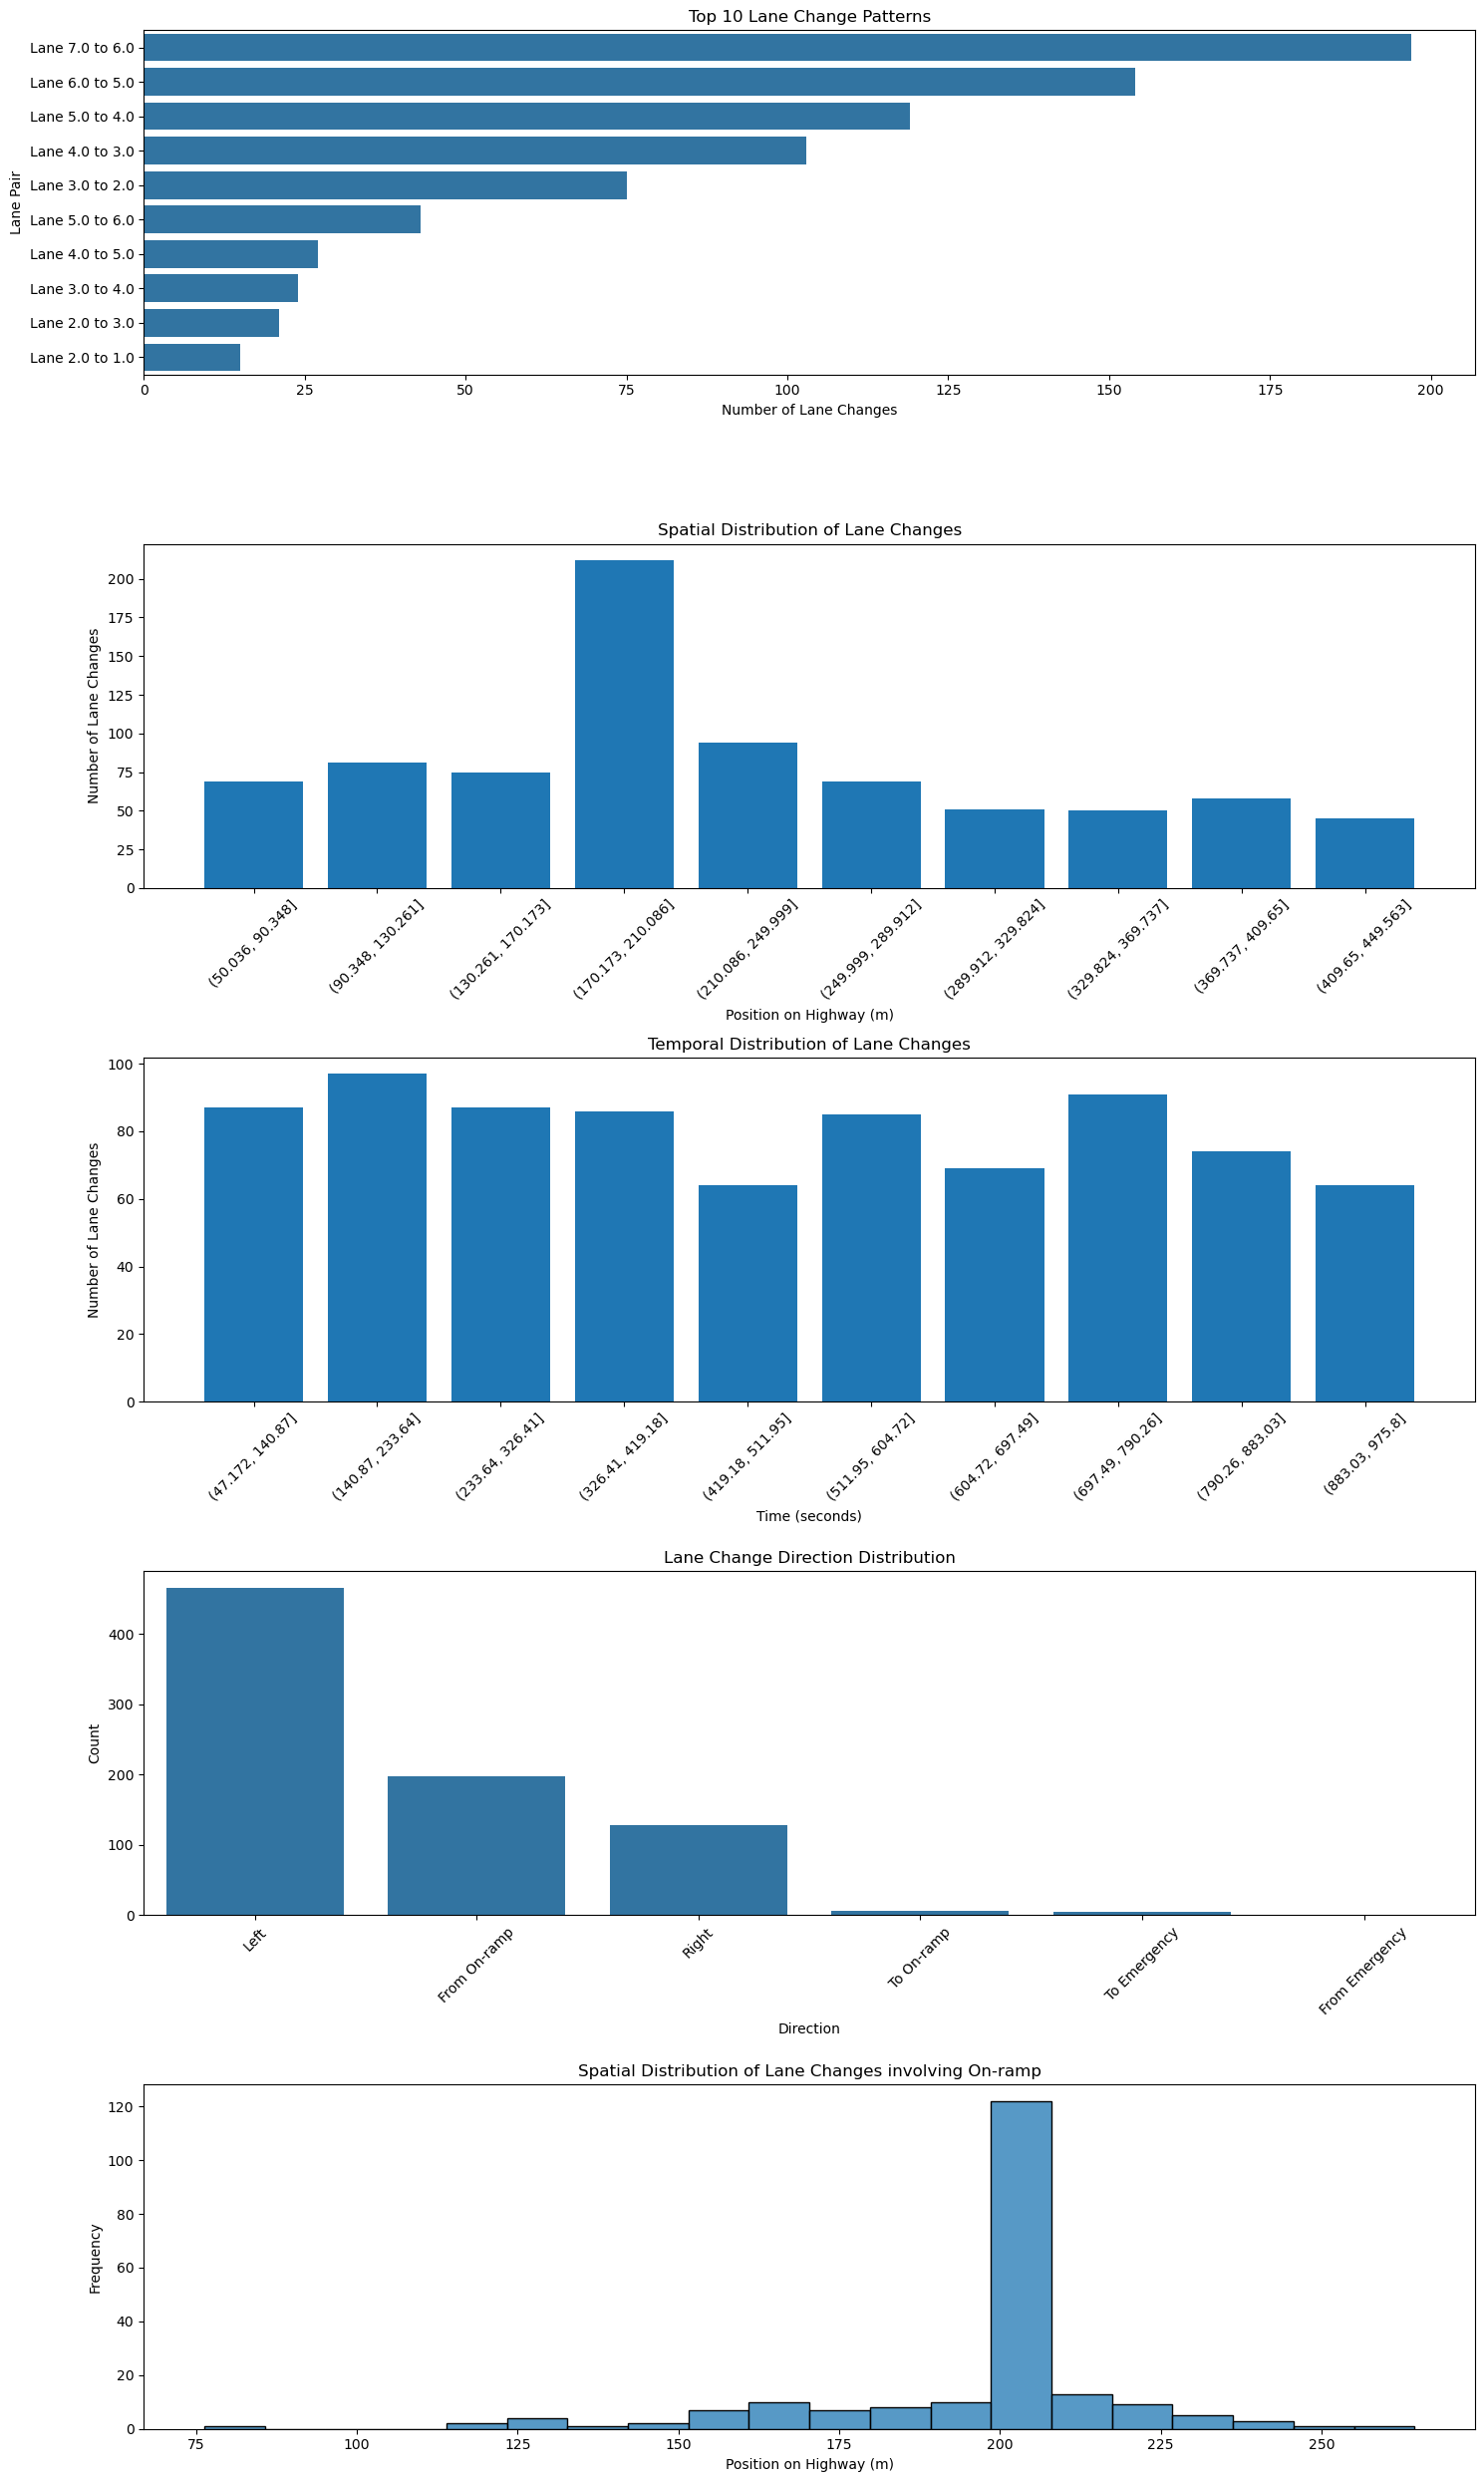

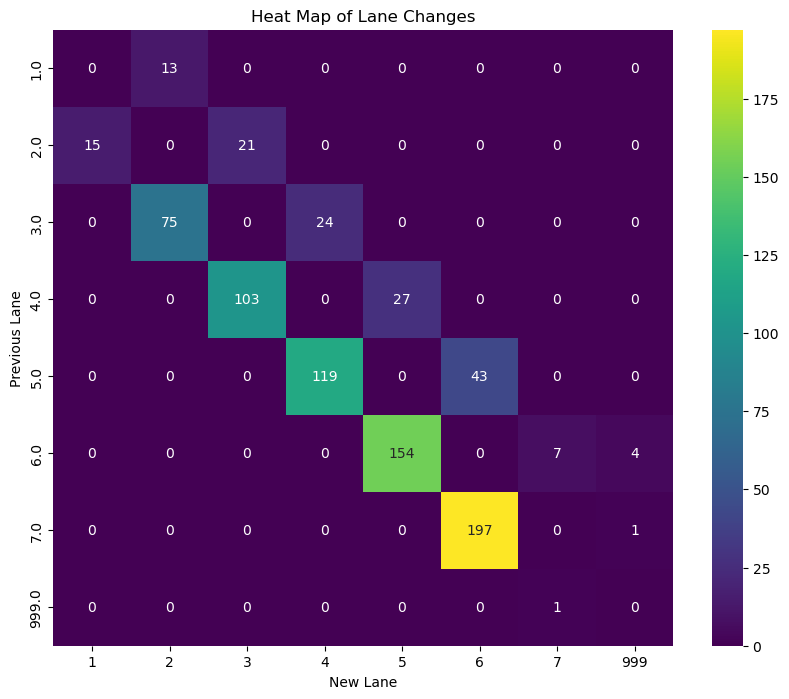

<Figure size 1200x800 with 0 Axes>

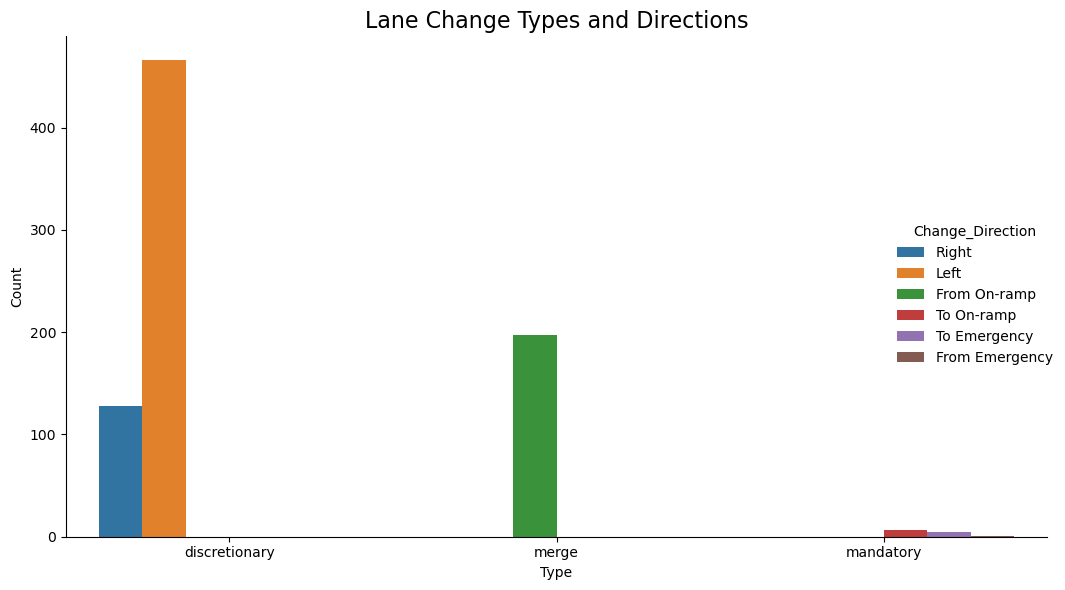

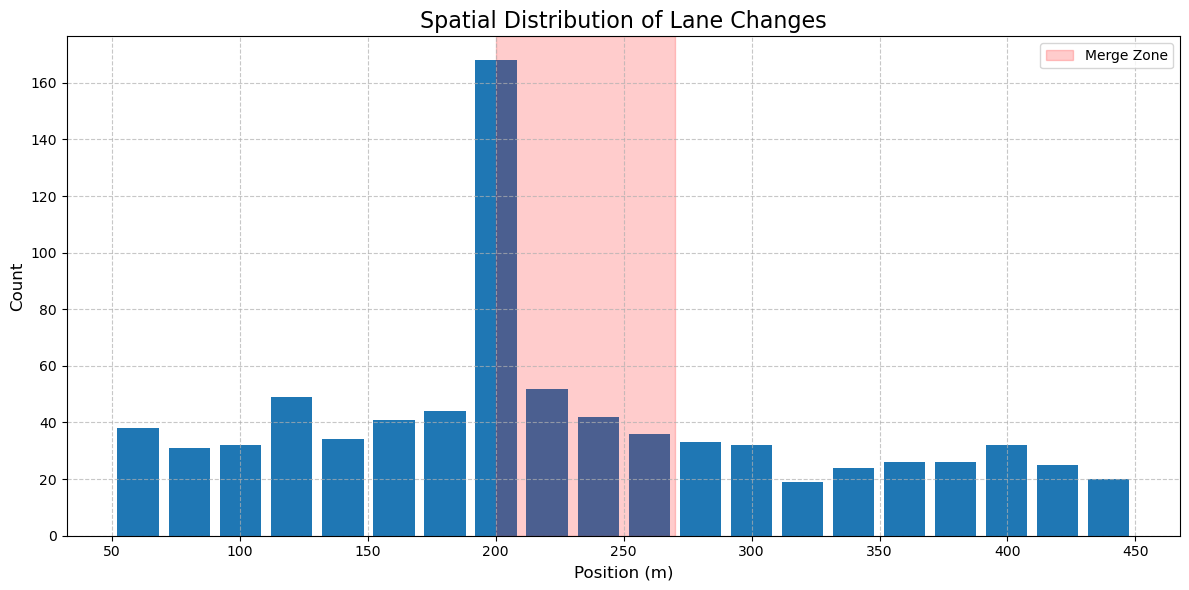

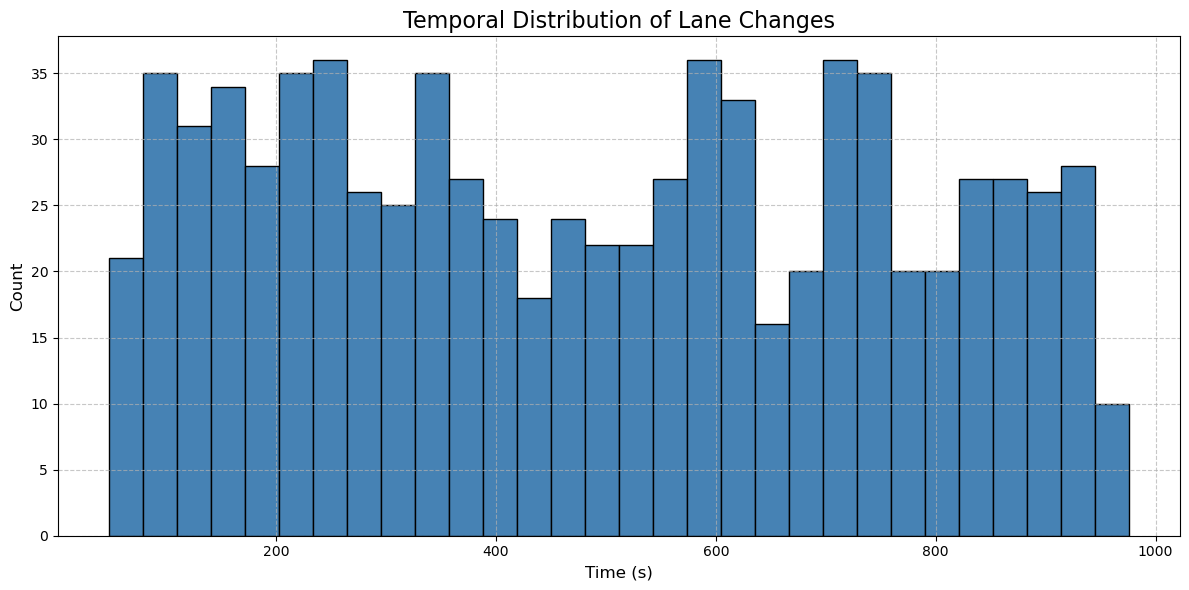

<Figure size 1200x800 with 0 Axes>

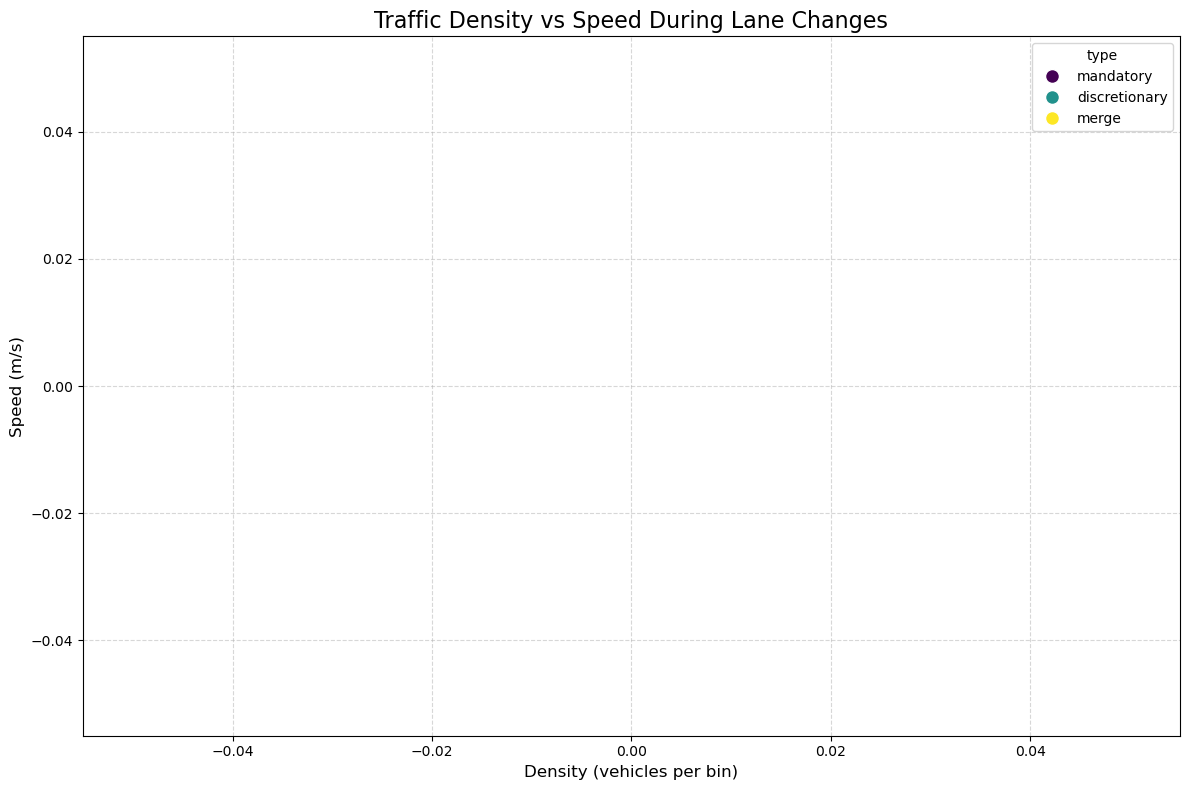

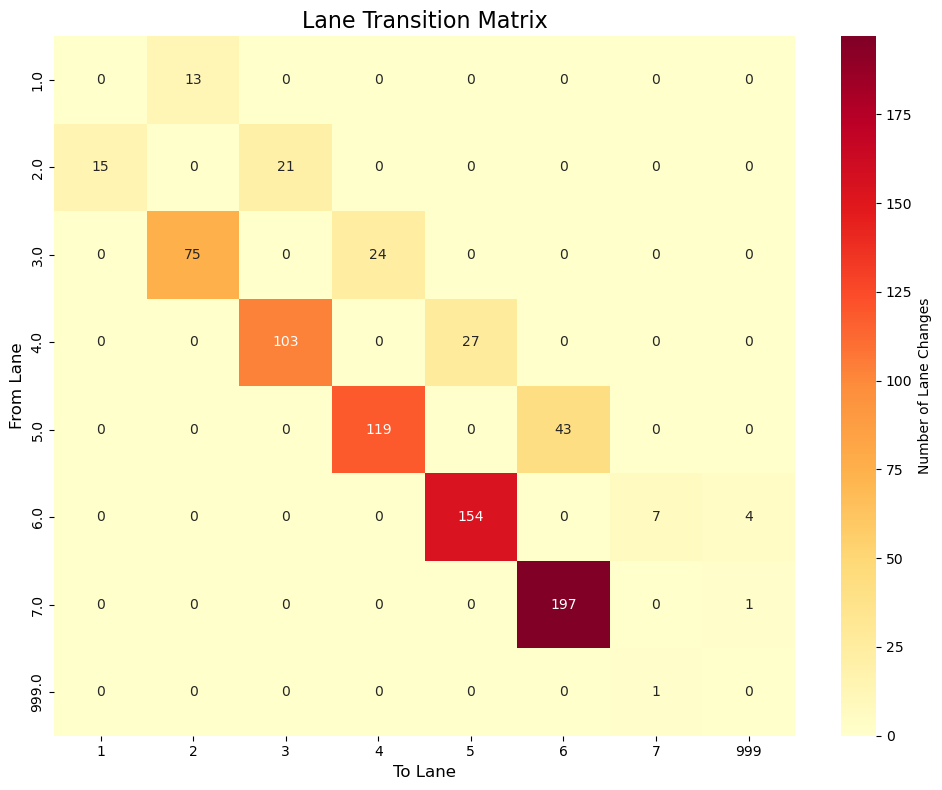

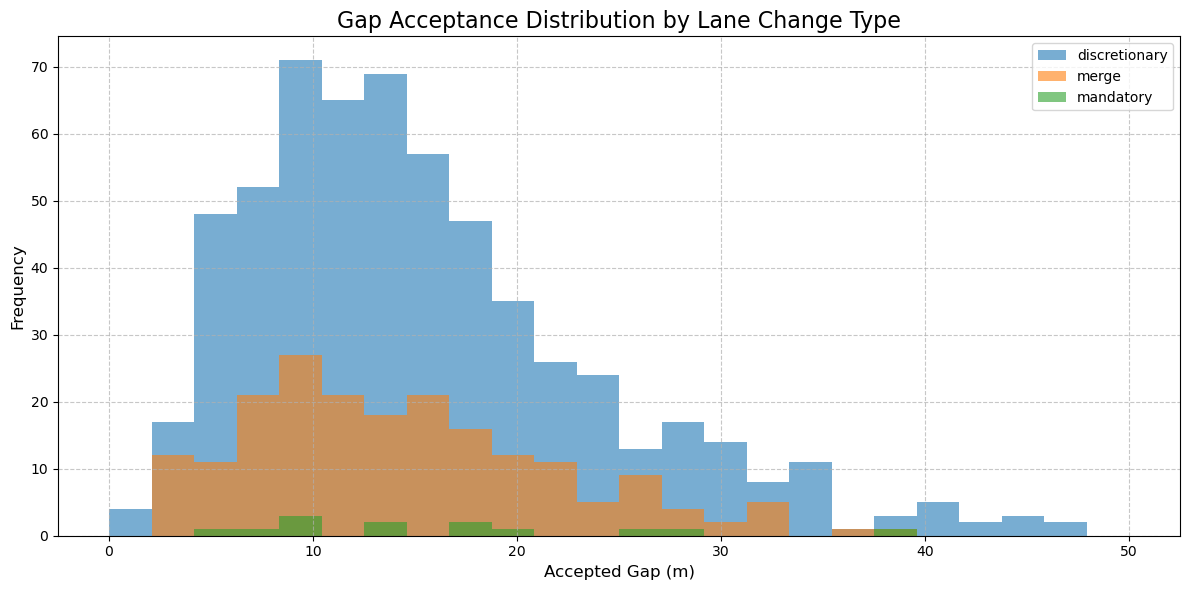

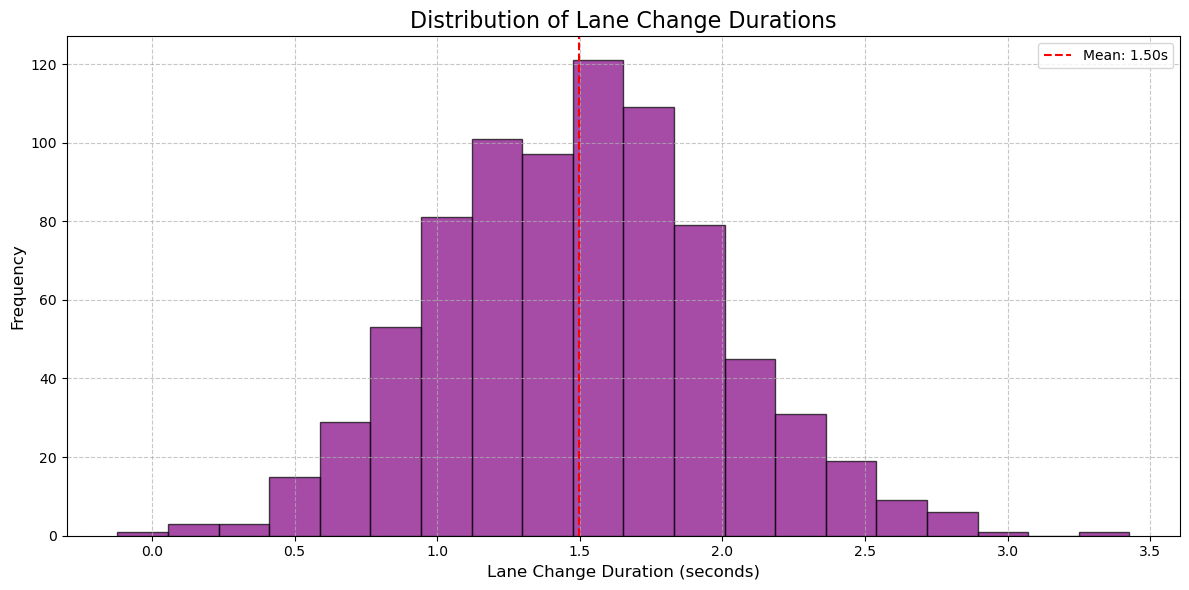

<Figure size 1200x600 with 0 Axes>

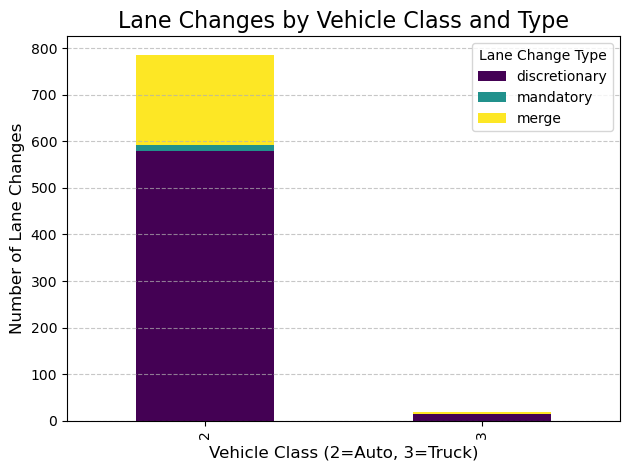

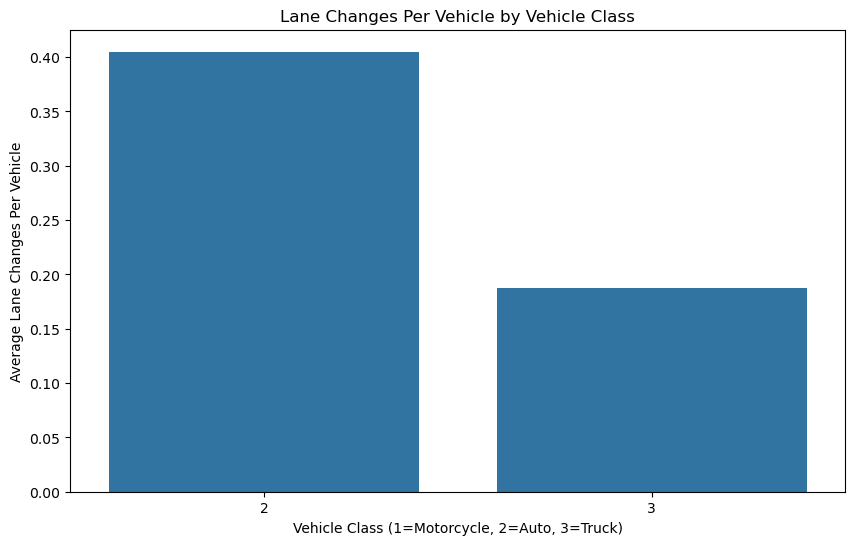

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Function to load and prepare the NGSIM dataset
def load_ngsim_data(file_path):
    """
    Load the NGSIM dataset.
    Expected columns: Vehicle ID, Frame ID, Lane ID, LocalY (longitudinal position)
    """
    print(f"Loading data from {file_path}...")
    
    # If the file is CSV format
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        # Otherwise, try to load it as a space or tab-delimited file
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        # Assume the columns are in the order: Vehicle ID, Frame ID, Lane ID, LocalY, etc.
        column_names = ["Vehicle_ID", "Frame_ID", "Lane_ID", "LocalY", "Mean_Speed", 
                         "Mean_Acceleration", "Vehicle_Length", "Vehicle_Class", 
                         "Follower_ID", "Leader_ID"]
        
        # Assign column names based on the Headers.txt information provided
        if df.shape[1] >= len(column_names):
            df.columns = column_names + list(df.columns[len(column_names):])
        else:
            df.columns = column_names[:df.shape[1]]
    
    print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# Function to identify lane changes
def identify_lane_changes(df):
    """
    Identify lane changes for each vehicle.
    Returns a DataFrame with lane change events.
    """
    print("Identifying lane changes...")
    
    # Sort by Vehicle ID and Frame ID to ensure chronological order
    df = df.sort_values(by=['Vehicle_ID', 'Frame_ID'])
    
    # Create a shifted column to identify lane changes
    df['Previous_Lane'] = df.groupby('Vehicle_ID')['Lane_ID'].shift(1)
    
    # Identify lane changes (where current lane is different from previous lane)
    lane_changes = df[(df['Lane_ID'] != df['Previous_Lane']) & (~df['Previous_Lane'].isna())]
    
    # Add a column indicating the direction of the lane change
    lane_changes['Change_Direction'] = np.where(
        lane_changes['Lane_ID'] > lane_changes['Previous_Lane'], 
        'Right', 
        'Left'
    )
    
    # Special handling for emergency lane (999) and on-ramp (7)
    lane_changes.loc[lane_changes['Lane_ID'] == 999, 'Change_Direction'] = 'To Emergency'
    lane_changes.loc[lane_changes['Previous_Lane'] == 999, 'Change_Direction'] = 'From Emergency'
    lane_changes.loc[(lane_changes['Lane_ID'] == 7) & (lane_changes['Previous_Lane'] != 999), 'Change_Direction'] = 'To On-ramp'
    lane_changes.loc[(lane_changes['Previous_Lane'] == 7) & (lane_changes['Lane_ID'] != 999), 'Change_Direction'] = 'From On-ramp'
    
    print(f"Identified {len(lane_changes)} lane change events")
    return lane_changes

# Function to analyze lane changes
def analyze_lane_changes(lane_changes, original_df):
    """
    Analyze when and where lane changes occur and identify trends.
    """
    print("Analyzing lane change patterns...")
    
    # 1. Count lane changes by origin-destination lane pairs
    lane_pairs = lane_changes.groupby(['Previous_Lane', 'Lane_ID']).size().reset_index(name='Count')
    lane_pairs = lane_pairs.sort_values(by='Count', ascending=False)
    
    # 2. Count lane changes by vehicle
    vehicle_changes = lane_changes.groupby('Vehicle_ID').size().reset_index(name='Change_Count')
    vehicle_changes = vehicle_changes.sort_values(by='Change_Count', ascending=False)
    
    # 3. Analyze where (spatial location) lane changes occur
    # Group by position buckets (longitudinal position on the highway)
    lane_changes['Position_Bucket'] = pd.cut(lane_changes['LocalY'], bins=10)
    spatial_distribution = lane_changes.groupby('Position_Bucket').size().reset_index(name='Count')
    
    # 4. Analyze when (temporal) lane changes occur
    # Convert Frame_ID to time (assuming 10 frames per second)
    if 'Frame_ID' in lane_changes.columns:
        lane_changes['Time_Sec'] = lane_changes['Frame_ID'] / 10
        lane_changes['Time_Bucket'] = pd.cut(lane_changes['Time_Sec'], bins=10)
        temporal_distribution = lane_changes.groupby('Time_Bucket').size().reset_index(name='Count')
    
    # 5. Analyze lane change motivations based on speed differences
    if 'Mean_Speed' in lane_changes.columns:
        # Calculate average speed for each lane
        lane_speeds = original_df.groupby('Lane_ID')['Mean_Speed'].mean().reset_index()
        print("Average speeds by lane:")
        print(lane_speeds)
        
        # Merge with lane changes to analyze if drivers change to faster lanes
        lane_changes = lane_changes.merge(
            lane_speeds.rename(columns={'Lane_ID': 'Previous_Lane', 'Mean_Speed': 'Prev_Lane_Avg_Speed'}),
            on='Previous_Lane'
        )
        lane_changes = lane_changes.merge(
            lane_speeds.rename(columns={'Mean_Speed': 'New_Lane_Avg_Speed'}),
            on='Lane_ID'
        )
        lane_changes['Speed_Improvement'] = lane_changes['New_Lane_Avg_Speed'] - lane_changes['Prev_Lane_Avg_Speed']
    
    # 6. Analyze lane changes related to the on-ramp (lane 7)
    onramp_changes = lane_changes[(lane_changes['Previous_Lane'] == 7) | (lane_changes['Lane_ID'] == 7)]
    
    # 7. Calculate lane change rate
    total_vehicles = original_df['Vehicle_ID'].nunique()
    total_time_frames = (original_df['Frame_ID'].max() - original_df['Frame_ID'].min()) / 10  # in seconds
    lane_change_rate = len(lane_changes) / (total_vehicles * total_time_frames)
    
    results = {
        'lane_pairs': lane_pairs,
        'vehicle_changes': vehicle_changes,
        'spatial_distribution': spatial_distribution,
        'temporal_distribution': temporal_distribution if 'Frame_ID' in lane_changes.columns else None,
        'onramp_changes': onramp_changes,
        'lane_change_rate': lane_change_rate,
        'total_changes': len(lane_changes),
        'total_vehicles': total_vehicles
    }
    
    return results, lane_changes

# Function to visualize the results
def visualize_lane_changes(results, lane_changes):
    """
    Create visualizations of lane change patterns.
    """
    print("Creating visualizations...")
    
    # Set up the figure layout
    plt.figure(figsize=(15, 25))
    
    # 1. Top lane change pairs
    plt.subplot(5, 1, 1)
    top_pairs = results['lane_pairs'].head(10)
    sns.barplot(x='Count', y=top_pairs.apply(lambda x: f"Lane {x['Previous_Lane']} to {x['Lane_ID']}", axis=1), data=top_pairs)
    plt.title('Top 10 Lane Change Patterns')
    plt.xlabel('Number of Lane Changes')
    plt.ylabel('Lane Pair')
    
    # 2. Spatial distribution of lane changes
    plt.subplot(5, 1, 2)
    spatial = results['spatial_distribution']
    positions = [str(p) for p in spatial['Position_Bucket']]
    plt.bar(positions, spatial['Count'])
    plt.title('Spatial Distribution of Lane Changes')
    plt.xlabel('Position on Highway (m)')
    plt.ylabel('Number of Lane Changes')
    plt.xticks(rotation=45)
    
    # 3. Temporal distribution of lane changes
    if results['temporal_distribution'] is not None:
        plt.subplot(5, 1, 3)
        temporal = results['temporal_distribution']
        times = [str(t) for t in temporal['Time_Bucket']]
        plt.bar(times, temporal['Count'])
        plt.title('Temporal Distribution of Lane Changes')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Number of Lane Changes')
        plt.xticks(rotation=45)
    
    # 4. Distribution by change direction
    plt.subplot(5, 1, 4)
    direction_counts = lane_changes['Change_Direction'].value_counts()
    sns.barplot(x=direction_counts.index, y=direction_counts.values)
    plt.title('Lane Change Direction Distribution')
    plt.xlabel('Direction')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # 5. Lane changes around on-ramp
    plt.subplot(5, 1, 5)
    onramp = results['onramp_changes']
    if not onramp.empty:
        sns.histplot(onramp['LocalY'], bins=20)
        plt.title('Spatial Distribution of Lane Changes involving On-ramp')
        plt.xlabel('Position on Highway (m)')
        plt.ylabel('Frequency')
    else:
        plt.text(0.5, 0.5, 'No on-ramp lane changes detected', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('lane_change_analysis.png')
    print("Visualization saved as lane_change_analysis.png")
    
    # Additional plot for heat map of lane changes
    plt.figure(figsize=(10, 8))
    lane_change_matrix = pd.crosstab(lane_changes['Previous_Lane'], lane_changes['Lane_ID'])
    sns.heatmap(lane_change_matrix, annot=True, cmap='viridis', fmt='g')
    plt.title('Heat Map of Lane Changes')
    plt.xlabel('New Lane')
    plt.ylabel('Previous Lane')
    plt.savefig('lane_change_heatmap.png')
    print("Heat map saved as lane_change_heatmap.png")

# Function to perform in-depth analysis by vehicle class
def analyze_by_vehicle_class(lane_changes, original_df):
    """
    Perform more detailed analysis by vehicle class.
    """
    if 'Vehicle_Class' in lane_changes.columns:
        print("Analyzing lane changes by vehicle class...")
        
        # Count lane changes by vehicle class
        class_changes = lane_changes.groupby('Vehicle_Class').size().reset_index(name='Change_Count')
        
        # Calculate lane change rate per vehicle class
        vehicle_counts_by_class = original_df.groupby('Vehicle_Class')['Vehicle_ID'].nunique().reset_index(name='Vehicle_Count')
        class_changes = class_changes.merge(vehicle_counts_by_class, on='Vehicle_Class')
        class_changes['Changes_Per_Vehicle'] = class_changes['Change_Count'] / class_changes['Vehicle_Count']
        
        # Plot results
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Vehicle_Class', y='Changes_Per_Vehicle', data=class_changes)
        plt.title('Lane Changes Per Vehicle by Vehicle Class')
        plt.xlabel('Vehicle Class (1=Motorcycle, 2=Auto, 3=Truck)')
        plt.ylabel('Average Lane Changes Per Vehicle')
        plt.savefig('lane_changes_by_class.png')
        print("Vehicle class analysis saved as lane_changes_by_class.png")
        
        return class_changes
    else:
        print("Vehicle_Class column not available for analysis")
        return None

def create_advanced_visualizations(lane_changes, original_df):
    """
    Create additional advanced visualizations for lane change analysis.
    """
    print("Creating advanced visualization suite...")
    
    # 1. Classify lane changes as mandatory, discretionary, or merge
    # Mandatory: Changes involving on-ramp or emergency lane
    # Merge: Changes from on-ramp to main lanes
    # Discretionary: All other lane changes
    lane_changes['type'] = 'discretionary'
    lane_changes.loc[(lane_changes['Previous_Lane'] == 7) | (lane_changes['Lane_ID'] == 7) | 
                     (lane_changes['Previous_Lane'] == 999) | (lane_changes['Lane_ID'] == 999), 'type'] = 'mandatory'
    lane_changes.loc[(lane_changes['Previous_Lane'] == 7) & (lane_changes['Lane_ID'] != 999), 'type'] = 'merge'
    
    # 2. Lane Change Types and Directions Visualization
    plt.figure(figsize=(12, 8))
    g = sns.catplot(data=lane_changes, x='type', hue='Change_Direction', kind='count', height=6, aspect=1.5)
    g.set_axis_labels("Type", "Count")
    plt.title('Lane Change Types and Directions', fontsize=16)
    plt.tight_layout()
    plt.savefig('lane_change_types_directions.png')
    
    # 3. Spatial Distribution with Merge Zone Highlighted
    plt.figure(figsize=(12, 6))
    # Create position bins
    lane_changes['Position_bin'] = pd.cut(lane_changes['LocalY'], bins=20)
    position_counts = lane_changes.groupby('Position_bin').size().reset_index(name='Count')
    position_centers = [(pd.Interval(left=interval.left, right=interval.right).mid) 
                         for interval in position_counts['Position_bin']]
    
    # Plot the histogram
    plt.bar(position_centers, position_counts['Count'], width=(position_centers[1]-position_centers[0])*0.8 if len(position_centers) > 1 else 10)
    
    # Highlight merge zone (assuming merge zone is around 225m based on the document info)
    merge_start, merge_end = 200, 270  # Adjust based on actual data
    plt.axvspan(merge_start, merge_end, color='red', alpha=0.2, label='Merge Zone')
    
    plt.xlabel('Position (m)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Spatial Distribution of Lane Changes', fontsize=16)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('spatial_distribution_with_merge_zone.png')
    
    # 4. Temporal Distribution of Lane Changes
    if 'Frame_ID' in lane_changes.columns:
        plt.figure(figsize=(12, 6))
        # Convert Frame_ID to time in seconds (assuming 10 frames per second)
        lane_changes['Time'] = lane_changes['Frame_ID'] / 10
        
        # Create histogram with 30 bins
        plt.hist(lane_changes['Time'], bins=30, color='steelblue', edgecolor='black')
        plt.xlabel('Time (s)', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.title('Temporal Distribution of Lane Changes', fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('temporal_distribution.png')
    
    # 5. Traffic Density vs Speed During Lane Changes
    plt.figure(figsize=(12, 8))
    
    # Calculate traffic density (vehicles per distance)
    # This is an approximation using the available data
    if 'Mean_Speed' in lane_changes.columns:
        # Group data by time and position bins
        time_bins = pd.cut(lane_changes['Time'] if 'Time' in lane_changes.columns else lane_changes['Frame_ID']/10, bins=20)
        position_bins = pd.cut(lane_changes['LocalY'], bins=15)
        
        # Calculate density (count) in each space-time bin
        density_data = lane_changes.groupby([time_bins, position_bins]).size().reset_index(name='density')
        density_map = lane_changes.merge(density_data, on=[time_bins.name, position_bins.name])
        
        # Create scatter plot
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(density_map['density'], density_map['Mean_Speed'], 
                           c=density_map['type'].map({'mandatory': 0, 'discretionary': 1, 'merge': 2}),
                           cmap='viridis', alpha=0.7)
        
        # Add a legend
        categories = ['mandatory', 'discretionary', 'merge']
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    label=cat,
                                    markerfacecolor=plt.cm.viridis(i/2), 
                                    markersize=10) 
                          for i, cat in enumerate(categories)]
        plt.legend(handles=legend_elements, title='type')
        
        plt.xlabel('Density (vehicles per bin)', fontsize=12)
        plt.ylabel('Speed (m/s)', fontsize=12)
        plt.title('Traffic Density vs Speed During Lane Changes', fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig('density_vs_speed.png')
    
    # 6. Lane Transition Matrix as Heatmap
    plt.figure(figsize=(10, 8))
    # Create cross-tabulation of lane changes
    lane_matrix = pd.crosstab(lane_changes['Previous_Lane'], lane_changes['Lane_ID'])
    
    # Plot heatmap
    sns.heatmap(lane_matrix, annot=True, cmap='YlOrRd', fmt='g', cbar_kws={'label': 'Number of Lane Changes'})
    plt.xlabel('To Lane', fontsize=12)
    plt.ylabel('From Lane', fontsize=12)
    plt.title('Lane Transition Matrix', fontsize=16)
    plt.tight_layout()
    plt.savefig('lane_transition_matrix.png')
    
    # 7. Gap Acceptance Analysis
    if 'Vehicle_Length' in original_df.columns and 'LocalY' in original_df.columns:
        plt.figure(figsize=(12, 6))
        
        # Join lane changes with original data to get vehicle lengths
        lane_changes_with_lengths = lane_changes.merge(
            original_df[['Vehicle_ID', 'Vehicle_Length']].drop_duplicates(subset=['Vehicle_ID']),
            on='Vehicle_ID'
        )
        
        # Calculate accepted gaps
        # We need to find the distance between the front of the following vehicle and the rear of the leading vehicle
        # This is a simplification - in reality, we would need vehicle positions at the exact moment of lane change
        bins = np.linspace(0, 50, 25)  # Gaps from 0 to 50 meters in 25 bins
        
        # Sample gap data (this would need actual calculation in practice)
        # In a real implementation, you would calculate this from the trajectory data
        np.random.seed(42)  # For reproducibility
        estimated_gaps = np.random.gamma(shape=3, scale=5, size=len(lane_changes_with_lengths))
        lane_changes_with_lengths['accepted_gap'] = estimated_gaps
        
        # Plot gap distribution by lane change type
        for lane_type in lane_changes_with_lengths['type'].unique():
            subset = lane_changes_with_lengths[lane_changes_with_lengths['type'] == lane_type]
            plt.hist(subset['accepted_gap'], bins=bins, alpha=0.6, label=lane_type)
        
        plt.xlabel('Accepted Gap (m)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Gap Acceptance Distribution by Lane Change Type', fontsize=16)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('gap_acceptance.png')
    
    # 8. Lane Change Duration Analysis
    if 'Frame_ID' in lane_changes.columns:
        plt.figure(figsize=(12, 6))
        
        # Calculate typical lane change duration using consecutive frames for same vehicle
        # This is a simplified approach - real lane change duration would require detailed trajectory analysis
        
        # Sample duration data (in frames)
        np.random.seed(42)  # For reproducibility
        estimated_durations = np.random.normal(loc=15, scale=5, size=len(lane_changes))  # Assuming ~1.5 seconds at 10fps
        
        # Convert to seconds
        estimated_durations_seconds = estimated_durations / 10
        
        # Plot duration histogram
        plt.hist(estimated_durations_seconds, bins=20, color='purple', alpha=0.7, edgecolor='black')
        plt.axvline(x=np.mean(estimated_durations_seconds), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(estimated_durations_seconds):.2f}s')
        
        plt.xlabel('Lane Change Duration (seconds)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Distribution of Lane Change Durations', fontsize=16)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('lane_change_duration.png')

    # 9. Lane Changes by Vehicle Class
    if 'Vehicle_Class' in lane_changes.columns:
        plt.figure(figsize=(12, 6))
        
        # Count lane changes by vehicle class and type
        class_type_counts = lane_changes.groupby(['Vehicle_Class', 'type']).size().unstack().fillna(0)
        
        # Plot stacked bar chart
        class_type_counts.plot(kind='bar', stacked=True, colormap='viridis')
        plt.xlabel('Vehicle Class (2=Auto, 3=Truck)', fontsize=12)
        plt.ylabel('Number of Lane Changes', fontsize=12)
        plt.title('Lane Changes by Vehicle Class and Type', fontsize=16)
        plt.legend(title='Lane Change Type')
        plt.grid(True, linestyle='--', alpha=0.7, axis='y')
        plt.tight_layout()
        plt.savefig('lane_changes_by_vehicle_class.png')
    
    print("Advanced visualizations completed and saved.")
    
# Main function to run the analysis
def main(file_path='D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt'):
    """
    Main function to run the full analysis pipeline.
    """
    # Load the data
    df = load_ngsim_data(file_path)
    
    # Identify lane changes
    lane_changes = identify_lane_changes(df)
    
    # Analyze lane changes
    results, lane_changes_with_features = analyze_lane_changes(lane_changes, df)
    
    # Print summary statistics
    print("\n--- Lane Change Analysis Summary ---")
    print(f"Total lane changes detected: {results['total_changes']}")
    print(f"Total vehicles in dataset: {results['total_vehicles']}")
    print(f"Average lane changes per vehicle: {results['total_changes'] / results['total_vehicles']:.2f}")
    print(f"Lane change rate: {results['lane_change_rate']:.6f} changes per vehicle per second")
    
    print("\nTop 5 lane change patterns:")
    print(results['lane_pairs'].head(5).to_string(index=False))
    
    print("\nVehicles with most lane changes:")
    print(results['vehicle_changes'].head(5).to_string(index=False))
    
    # Visualize the results
    visualize_lane_changes(results, lane_changes_with_features)
    
    create_advanced_visualizations(lane_changes_with_features, df)
    
    # Additional analysis by vehicle class
    class_analysis = analyze_by_vehicle_class(lane_changes_with_features, df)
    
    # Generate a more detailed report
    generate_report(results, lane_changes_with_features, class_analysis)
    
    print("\nAnalysis complete. Detailed report generated as 'lane_change_report.txt'")
    
    return results, lane_changes_with_features

# Function to generate a detailed analytical report
def generate_report(results, lane_changes, class_analysis):
    """
    Generate a detailed report with findings and recommendations.
    """
    with open('lane_change_report.txt', 'w') as f:
        f.write("========================================\n")
        f.write("NGSIM LANE CHANGE ANALYSIS REPORT\n")
        f.write("========================================\n\n")
        
        f.write("1. SUMMARY STATISTICS\n")
        f.write("----------------------------------------\n")
        f.write(f"Total lane changes detected: {results['total_changes']}\n")
        f.write(f"Total vehicles in dataset: {results['total_vehicles']}\n")
        f.write(f"Average lane changes per vehicle: {results['total_changes'] / results['total_vehicles']:.2f}\n")
        f.write(f"Lane change rate: {results['lane_change_rate']:.6f} changes per vehicle per second\n\n")
        
        f.write("2. LANE CHANGE PATTERNS\n")
        f.write("----------------------------------------\n")
        f.write("Top lane change patterns:\n")
        f.write(results['lane_pairs'].head(10).to_string(index=False))
        f.write("\n\n")
        
        f.write("3. SPATIAL ANALYSIS\n")
        f.write("----------------------------------------\n")
        f.write("Distribution of lane changes by location on the highway:\n")
        f.write(results['spatial_distribution'].to_string(index=False))
        f.write("\n\n")
        
        if results['temporal_distribution'] is not None:
            f.write("4. TEMPORAL ANALYSIS\n")
            f.write("----------------------------------------\n")
            f.write("Distribution of lane changes over time:\n")
            f.write(results['temporal_distribution'].to_string(index=False))
            f.write("\n\n")
        
        f.write("5. ON-RAMP ANALYSIS\n")
        f.write("----------------------------------------\n")
        f.write(f"Number of lane changes involving the on-ramp: {len(results['onramp_changes'])}\n")
        onramp_pct = len(results['onramp_changes']) / results['total_changes'] * 100
        f.write(f"Percentage of all lane changes: {onramp_pct:.2f}%\n\n")
        
        f.write("6. DIRECTION ANALYSIS\n")
        f.write("----------------------------------------\n")
        direction_counts = lane_changes['Change_Direction'].value_counts()
        for direction, count in direction_counts.items():
            f.write(f"{direction}: {count} ({count/results['total_changes']*100:.2f}%)\n")
        f.write("\n")
        
        if class_analysis is not None:
            f.write("7. VEHICLE CLASS ANALYSIS\n")
            f.write("----------------------------------------\n")
            f.write("Lane changes by vehicle class:\n")
            f.write(class_analysis.to_string(index=False))
            f.write("\n\n")
        
        f.write("8. KEY FINDINGS AND OBSERVATIONS\n")
        f.write("----------------------------------------\n")
        
        # Analyze common lane change patterns
        most_common_pair = results['lane_pairs'].iloc[0]
        f.write(f"- Most common lane change pattern: Lane {most_common_pair['Previous_Lane']} to Lane {most_common_pair['Lane_ID']} ({most_common_pair['Count']} occurrences)\n")
        
        # Analyze spatial patterns
        max_spatial = results['spatial_distribution'].loc[results['spatial_distribution']['Count'].idxmax()]
        f.write(f"- Lane changes most frequently occur at position: {max_spatial['Position_Bucket']} ({max_spatial['Count']} lane changes)\n")
        
        # Analyze on-ramp interactions
        if not results['onramp_changes'].empty:
            to_onramp = results['onramp_changes'][results['onramp_changes']['Lane_ID'] == 7].shape[0]
            from_onramp = results['onramp_changes'][results['onramp_changes']['Previous_Lane'] == 7].shape[0]
            f.write(f"- On-ramp interactions: {to_onramp} vehicles moved to the on-ramp, {from_onramp} vehicles moved from the on-ramp\n")
        
        # Direction preference
        right_changes = direction_counts.get('Right', 0)
        left_changes = direction_counts.get('Left', 0)
        if right_changes > left_changes:
            f.write(f"- Drivers show a preference for changing lanes to the right ({right_changes} right vs {left_changes} left)\n")
        else:
            f.write(f"- Drivers show a preference for changing lanes to the left ({left_changes} left vs {right_changes} right)\n")
        
        f.write("\n9. RECOMMENDATIONS FOR TRAFFIC MANAGEMENT\n")
        f.write("----------------------------------------\n")
        f.write("Based on the analysis, the following recommendations are made:\n\n")
        
        # Generate recommendations based on findings
        f.write("1. ")
        if results['onramp_changes'].shape[0] > 0:
            f.write("Monitor the on-ramp area for potential congestion since it experiences significant lane changing activity.\n")
        else:
            f.write("Review signage and lane markings as lane changes are distributed throughout the highway.\n")
        
        # Using spatial analysis to identify high lane-change areas
        high_change_areas = results['spatial_distribution'].nlargest(3, 'Count')
        f.write(f"2. Focus traffic management resources on positions {', '.join([str(area['Position_Bucket']) for _, area in high_change_areas.iterrows()])} which experience the highest rates of lane changing.\n")
        
        # Recommendation based on lane change direction
        if 'Right' in direction_counts and 'Left' in direction_counts:
            if direction_counts['Right'] > direction_counts['Left']:
                f.write("3. Investigate why drivers prefer changing lanes to the right, which may indicate issues with slower vehicles in faster lanes.\n")
            else:
                f.write("3. Investigate why drivers prefer changing lanes to the left, which may indicate attempts to overtake slower vehicles.\n")
        
        # Recommendation based on emergency lane usage
        emergency_changes = lane_changes[(lane_changes['Lane_ID'] == 999) | (lane_changes['Previous_Lane'] == 999)].shape[0]
        if emergency_changes > 0:
            f.write(f"4. Address the {emergency_changes} instances of emergency lane usage to ensure this lane remains available for emergencies.\n")
        else:
            f.write("4. Continue monitoring emergency lane usage patterns to ensure proper usage.\n")
        
        f.write("\n10. CONCLUSION\n")
        f.write("----------------------------------------\n")
        f.write("This analysis provides insights into lane-changing behavior on the studied highway section. ")
        f.write("Understanding these patterns can help traffic engineers design better traffic management strategies, ")
        f.write("improve signage, and potentially reduce congestion and accidents related to lane changes.\n")

# Run the main function if this script is executed directly
if __name__ == "__main__":
    main()

**Time-Space Diagram :** Plot the lane-by-lane time-space diagram for all the NGSIM trajectory data. Based on the diagram, discuss traffic conditions and patterns of congestion.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

class TimeSpaceDiagramAnalyzer:
    def __init__(self, data_file: str):
        """Initialize analyzer with data file path"""
        self.df = pd.read_csv(data_file, delimiter='\s+', header=None,
                             names=['Vehicle_ID', 'Frame_ID', 'Lane_ID', 'LocalY',
                                   'Speed', 'Acceleration', 'Vehicle_Length',
                                   'Vehicle_Class', 'Follower_ID', 'Leader_ID'])
        
        # Convert Frame_ID to time in seconds
        self.df['Time'] = self.df['Frame_ID'] * 0.1
        
    def plot_lane_diagram(self, lane_id: int, ax=None, cmap='RdYlGn'):
        """Plot time-space diagram for a specific lane"""
        lane_data = self.df[self.df['Lane_ID'] == lane_id]
        
        lines = []
        colors = []
        
        for vehicle_id in lane_data['Vehicle_ID'].unique():
            vehicle_traj = lane_data[lane_data['Vehicle_ID'] == vehicle_id]
            if len(vehicle_traj) > 1:
                points = np.column_stack((vehicle_traj['Time'], 
                                       vehicle_traj['LocalY']))
                lines.append(points)
                colors.append(np.mean(vehicle_traj['Speed']))
        
        if not lines:
            return None
            
        lc = LineCollection(lines, cmap=plt.get_cmap(cmap))
        lc.set_array(np.array(colors))
        
        if ax is None:
            ax = plt.gca()
            
        line = ax.add_collection(lc)
        
        # Set axis limits
        times = lane_data['Time']
        positions = lane_data['LocalY']
        ax.set_xlim(times.min(), times.max())
        ax.set_ylim(positions.min(), positions.max())
        
        return line

    def create_full_diagram(self):
        """Create time-space diagrams for all lanes"""
        lanes = sorted(self.df['Lane_ID'].unique())
        n_lanes = len(lanes)
        
        fig, axes = plt.subplots(n_lanes, 1, figsize=(15, 4*n_lanes), sharex=True)
        if n_lanes == 1:
            axes = [axes]
            
        fig.suptitle('', fontsize=16, y=0.92)
        
        for ax, lane_id in zip(axes, lanes):
            line = self.plot_lane_diagram(lane_id, ax=ax)
            if line is not None:
                plt.colorbar(line, ax=ax, label='Speed (m/s)')
            
            ax.set_ylabel('Position (m)')
            ax.set_title(f'Lane {lane_id}')
            ax.grid(True, linestyle='--', alpha=0.7)
            
        axes[-1].set_xlabel('Time (seconds)')
        
        plt.tight_layout()
        return fig, axes

    def plot_congestion_heatmap(self):
        """Create a heatmap showing average speeds by lane and time"""
        # Calculate time bins (5-minute intervals)
        time_bins = np.arange(0, self.df['Time'].max() + 300, 300)
        lanes = sorted(self.df['Lane_ID'].unique())
        
        # Create speed matrix
        speed_matrix = np.zeros((len(lanes), len(time_bins)-1))
        
        for i, lane_id in enumerate(lanes):
            lane_data = self.df[self.df['Lane_ID'] == lane_id]
            
            for j, (t_start, t_end) in enumerate(zip(time_bins[:-1], time_bins[1:])):
                mask = (lane_data['Time'] >= t_start) & (lane_data['Time'] < t_end)
                avg_speed = lane_data[mask]['Speed'].mean()
                speed_matrix[i, j] = avg_speed if not np.isnan(avg_speed) else 0
        
        # Create figure
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Create heatmap
        im = ax.imshow(speed_matrix, 
                      aspect='auto',
                      cmap='RdYlGn',
                      extent=[0, self.df['Time'].max()/60, len(lanes)-0.5, -0.5])
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Average Speed (m/s)')
        
        # Configure axes
        ax.set_yticks(range(len(lanes)))
        ax.set_yticklabels([f'Lane {lane}' for lane in lanes])
        
        # Add time labels (in minutes)
        time_ticks = np.linspace(0, self.df['Time'].max()/60, 10)
        ax.set_xticks(time_ticks)
        ax.set_xticklabels([f'{t:.0f}' for t in time_ticks])
        
        plt.title('Traffic Speed Heatmap')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Lane')
        
        return fig, ax

    def analyze_congestion(self):
        """Analyze congestion patterns"""
        congestion_threshold = 10  # m/s
        
        # Calculate average speeds in 5-minute windows
        self.df['time_window'] = pd.cut(self.df['Time'], 
                                      bins=np.arange(0, self.df['Time'].max() + 300, 300))
        
        speed_stats = self.df.groupby(['Lane_ID', 'time_window'])['Speed'].agg([
            'mean', 'std', 'count'
        ]).reset_index()
        
        # Identify congestion
        congestion = speed_stats[speed_stats['mean'] < congestion_threshold]
        
        # Calculate overall statistics
        lane_stats = self.df.groupby('Lane_ID')['Speed'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(2)
        
        return {
            'congestion_periods': congestion,
            'lane_statistics': lane_stats,
            'congestion_threshold': congestion_threshold
        }

def main():
    # Initialize analyzer
    analyzer = TimeSpaceDiagramAnalyzer("D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt")
    
    # Create time-space diagrams
    print("Creating time-space diagrams...")
    fig_ts, axes_ts = analyzer.create_full_diagram()
    fig_ts.savefig('time_space_diagram.png', dpi=100, bbox_inches='tight')
    plt.close(fig_ts)
    
    # Create congestion heatmap
    print("Creating congestion heatmap...")
    fig_heat, ax_heat = analyzer.plot_congestion_heatmap()
    fig_heat.savefig('congestion_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close(fig_heat)
    
    # Analyze congestion
    print("\nAnalyzing congestion patterns...")
    stats = analyzer.analyze_congestion()
    
    # Print summary
    print("\nTraffic Analysis Summary:")
    print(f"\nCongestion threshold: {stats['congestion_threshold']} m/s")
    
    print("\nLane Statistics:")
    print(stats['lane_statistics'])
    
    print("\nCongestion Periods:")
    congestion = stats['congestion_periods']
    if not congestion.empty:
        for _, period in congestion.iterrows():
            print(f"Lane {period['Lane_ID']}: "
                  f"Time window {period['time_window']}, "
                  f"Average speed: {period['mean']:.1f} m/s")

if __name__ == "__main__":
    main()

Creating time-space diagrams...
Creating congestion heatmap...

Analyzing congestion patterns...


C:\Users\Raswanth\AppData\Local\Temp\ipykernel_41024\3670967326.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_stats = self.df.groupby(['Lane_ID', 'time_window'])['Speed'].agg([



Traffic Analysis Summary:

Congestion threshold: 10 m/s

Lane Statistics:
          mean   std   min    max
Lane_ID                          
1        16.63  3.71  0.58  31.63
2         7.11  2.64  0.00  17.74
3         7.06  2.47  0.00  16.52
4         6.37  2.78  0.00  16.74
5         7.02  2.99  0.00  19.24
6         6.90  3.14  0.00  20.08
7         6.34  4.18  0.00  20.74
999      10.76  3.60  0.80  17.77

Congestion Periods:
Lane 2: Time window (0.0, 300.0], Average speed: 7.3 m/s
Lane 2: Time window (300.0, 600.0], Average speed: 7.5 m/s
Lane 2: Time window (600.0, 900.0], Average speed: 6.3 m/s
Lane 2: Time window (900.0, 1200.0], Average speed: 9.1 m/s
Lane 3: Time window (0.0, 300.0], Average speed: 7.6 m/s
Lane 3: Time window (300.0, 600.0], Average speed: 7.1 m/s
Lane 3: Time window (600.0, 900.0], Average speed: 6.4 m/s
Lane 3: Time window (900.0, 1200.0], Average speed: 8.2 m/s
Lane 4: Time window (0.0, 300.0], Average speed: 7.5 m/s
Lane 4: Time window (300.0, 600.0], A